<font size="+3.8">Sample-level Pseudobulking</font>  
<font size="+1.5">ABC Atlas (Yao 2023 Nature)</font>  


See ABC Atlas documentation: https://alleninstitute.github.io/abc_atlas_access/notebooks/10x_snRNASeq_tutorial_part_1.html

Loads the ABC Atlas and creates sample-level pseudobulks.   

Previously worked on cell-level anndata object (v2,v3,Multi) which has 4M cells and ca. 200 GB. Loading and merging functions operate successfully on the cluster, but additional processing exceeds memory (see other script). Possible solutions:
1. Pseudobulking (per sample and celltype) -- best option for DE analysis anyway, see this script
2. RAPIDS-singlecell (GPU accelerated), preliminary set up, see other script -- not used
3. Downsampling cells -- not implemented

In [1]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import os
import sys
from datetime import date
from glob import glob
from time import time

import numpy as np
import pandas as pd
import scipy.sparse

In [3]:
import matplotlib.pyplot as plt

In [4]:
import anndata as ad
import scanpy as sc

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [5]:
data_dir = "/cluster2/sfrerich/P18_cellseg_benchmark"

In [6]:
#data_dir = os.path.abspath("../home/data")
#!ls -l $data_dir

In [7]:
abc_download_dir =  os.path.join(
        data_dir,
        "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "raw-downloaded")

# Helper functions

In [8]:
import random


# adapted from https://www.sc-best-practices.org/conditions/differential_gene_expression.html
def pseudobulk_aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i + 1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )

    return adata_cell_pop

# Format cell metadata

Meta data is saved in separate files: load, merge, format

In [9]:
os.listdir(
    os.path.join(
        abc_download_dir,
        "metadata",
        "WMB-10X",
        "20241115",
    )
)

['cell_metadata.csv', 'views', 'gene.csv', 'region_of_interest_metadata.csv']

In [10]:
cell = pd.read_csv(
    os.path.join(
        abc_download_dir,
        "metadata",
        "WMB-10X",
        "20241115",
        "cell_metadata.csv",
    ),
    dtype={"cell_label": str},
)
cell.set_index("cell_label", inplace=True)
print("Number of cells = ", len(cell))

Number of cells =  4042976


In [11]:
cell.shape

(4042976, 16)

In [12]:
cell.head(2)

cell_barcode barcoded_cell_sample_label  \
cell_label                                                              
GCGAGAAGTTAAGGGC-410_B05  GCGAGAAGTTAAGGGC                    410_B05   
AATGGCTCAGCTCCTT-411_B06  AATGGCTCAGCTCCTT                    411_B06   

                               library_label feature_matrix_label entity  \
cell_label                                                                 
GCGAGAAGTTAAGGGC-410_B05  L8TX_201030_01_C12        WMB-10Xv3-HPF   cell   
AATGGCTCAGCTCCTT-411_B06  L8TX_201029_01_E10        WMB-10Xv3-HPF   cell   

                          brain_section_label library_method  \
cell_label                                                     
GCGAGAAGTTAAGGGC-410_B05                  NaN          10Xv3   
AATGGCTCAGCTCCTT-411_B06                  NaN          10Xv3   

                         region_of_interest_acronym  \
cell_label                                            
GCGAGAAGTTAAGGGC-410_B05                        RHP   
AATGGCTCAGCTCCTT-411_B06                        RHP   

                                           donor_label    donor_genotype  \
cell_label                                                                 
GCGAGAAGTTAAGGGC-410_B05  Snap25-IRES2-Cre;Ai14-550850  Ai14(RCL-tdT)/wt   
AATGGCTCAGCTCCTT-411_B06  Snap25-IRES2-Cre;Ai14-550851  Ai14(RCL-tdT)/wt   

                         donor_sex dataset_label          x         y  \
cell_label                                                              
GCGAGAAGTTAAGGGC-410_B05         F     WMB-10Xv3  23.146826 -3.086639   
AATGGCTCAGCTCCTT-411_B06         F     WMB-10Xv3  23.138481 -3.022000   

                          cluster_alias                         abc_sample_id  
cell_label                                                                     
GCGAGAAGTTAAGGGC-410_B05              1  484be5df-5d44-4bfe-9652-7b5bc739c211  
AATGGCTCAGCTCCTT-411_B06              1  5638505d-e1e8-457f-9e5b-59e3e2302417

In [13]:
cell.groupby("dataset_label")[["x"]].count()

x
dataset_label         
WMB-10XMulti      1687
WMB-10Xv2      1699939
WMB-10Xv3      2341350

In [14]:
def print_column_info(df):
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ""
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))

In [15]:
print_column_info(cell)

Number of unique cell_barcode = 2375490 
Number of unique barcoded_cell_sample_label = 819 
Number of unique library_label = 819 
Number of unique feature_matrix_label = 24 ['WMB-10XMulti', 'WMB-10Xv2-CTXsp', 'WMB-10Xv2-HPF', 'WMB-10Xv2-HY', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-Isocortex-2', 'WMB-10Xv2-Isocortex-3', 'WMB-10Xv2-Isocortex-4', 'WMB-10Xv2-MB', 'WMB-10Xv2-OLF', 'WMB-10Xv2-TH', 'WMB-10Xv3-CB', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HPF', 'WMB-10Xv3-HY', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-Isocortex-2', 'WMB-10Xv3-MB', 'WMB-10Xv3-MY', 'WMB-10Xv3-OLF', 'WMB-10Xv3-P', 'WMB-10Xv3-PAL', 'WMB-10Xv3-STR', 'WMB-10Xv3-TH']
Number of unique entity = 1 ['cell']
Number of unique brain_section_label = 0 []
Number of unique library_method = 3 ['10Xv2', '10Xv3', '10xRSeq_Mult']
Number of unique region_of_interest_acronym = 29 ['ACA', 'AI', 'AUD', 'AUD-TEa-PERI-ECT', 'CB', 'CTXsp', 'ENT', 'HIP', 'HY', 'LSX', 'MB', 'MO-FRP', 'MOp', 'MY', 'OLF', 'P', 'PAL', 'PL-ILA-ORB', 'RHP', 'RSP', 'SS-GU-VISC', 'SS

In [16]:
# cell type annotations

In [17]:
os.listdir(
    os.path.join(
        abc_download_dir,
        "metadata",
        "WMB-taxonomy",
        "20231215",
    )
)

['cluster_annotation_term_set.csv',
 'cluster_to_cluster_annotation_membership.csv',
 'views',
 'cluster_annotation_term.csv',
 'cluster.csv']

In [18]:
meta_ct = pd.read_csv(
    os.path.join(
        abc_download_dir,
        "metadata",
        "WMB-taxonomy",
        "20231215",
        "cluster.csv",
    )
)

In [19]:
meta_ct.shape

(5322, 3)

In [20]:
meta_ct.head(5)

cluster_alias  number_of_cells            label
0              1              727  CS20230722_0001
1             10              740  CS20230722_0010
2            100             1053  CS20230722_0100
3           1000               59  CS20230722_1000
4           1001               96  CS20230722_1001

In [21]:
cluster_details = pd.read_csv(
    os.path.join(
        abc_download_dir,
        "metadata",
        "WMB-taxonomy",
        "20231215",
        "views",
        "cluster_to_cluster_annotation_membership_pivoted.csv",
    )
)
cluster_details.set_index("cluster_alias", inplace=True)
cluster_details.shape

(5322, 5)

In [22]:
cluster_details.head(5)

neurotransmitter          class                subclass  \
cluster_alias                                                           
1                         Glut  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
2                         Glut  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
3                         Glut  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
4                         Glut  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
5                         Glut  01 IT-ET Glut  018 L2 IT PPP-APr Glut   

                               supertype                    cluster  
cluster_alias                                                        
1              0082 L2 IT PPP-APr Glut_3  0326 L2 IT PPP-APr Glut_3  
2              0082 L2 IT PPP-APr Glut_3  0327 L2 IT PPP-APr Glut_3  
3              0081 L2 IT PPP-APr Glut_2  0322 L2 IT PPP-APr Glut_2  
4              0081 L2 IT PPP-APr Glut_2  0323 L2 IT PPP-APr Glut_2  
5              0081 L2 IT PPP-APr Glut_2  0325 L2 IT PPP-APr Glut_2

In [23]:
cluster_colors = pd.read_csv(
    os.path.join(
        abc_download_dir,
        "metadata",
        "WMB-taxonomy",
        "20231215",
        "views",
        "cluster_to_cluster_annotation_membership_color.csv",
    )
)
cluster_colors.set_index("cluster_alias", inplace=True)
cluster_colors.shape

(5322, 5)

In [24]:
cluster_colors.head(5)

neurotransmitter_color class_color subclass_color  \
cluster_alias                                                     
1                            #2B93DF     #FA0087        #0F6632   
2                            #2B93DF     #FA0087        #0F6632   
3                            #2B93DF     #FA0087        #0F6632   
4                            #2B93DF     #FA0087        #0F6632   
5                            #2B93DF     #FA0087        #0F6632   

              supertype_color cluster_color  
cluster_alias                                
1                     #266DFF       #64661F  
2                     #266DFF       #CCA73D  
3                     #002BCC       #99000D  
4                     #002BCC       #5C8899  
5                     #002BCC       #473D66

In [25]:
roi = pd.read_csv(
    os.path.join(
        abc_download_dir,
        "metadata",
        "WMB-10X",
        "20241115",
        "region_of_interest_metadata.csv",
    )
)
roi.rename(
    columns={
        "order": "region_of_interest_order",
        "color_hex_triplet": "region_of_interest_color",
    },
    inplace=True,
)
roi.set_index("acronym", inplace=True)
roi.shape

(29, 4)

In [26]:
roi.head(5)

label                                    name  \
acronym                                                              
MO-FRP          WMB-MO-FRP              Somatomotor - Frontal pole   
MOp                WMB-MOp                      Primary motor area   
SS-GU-VISC  WMB-SS-GU-VISC  Somatosensory/gustatory/visceral areas   
SSp                WMB-SSp              Primary somatosensory area   
AUD                WMB-AUD                          Auditory areas   

            region_of_interest_order region_of_interest_color  
acronym                                                        
MO-FRP                             0                  #3DCC7C  
MOp                                1                  #179968  
SS-GU-VISC                         2                  #2E8599  
SSp                                3                  #5CCCCC  
AUD                                4                  #455A99

## Merge meta tables

In [27]:
cell_extended = cell.join(cluster_details, on="cluster_alias")
cell_extended = cell_extended.join(cluster_colors, on="cluster_alias")
cell_extended = cell_extended.join(
    roi[["region_of_interest_order", "region_of_interest_color"]],
    on="region_of_interest_acronym",
)
cell_extended.head(2)

cell_barcode barcoded_cell_sample_label  \
cell_label                                                              
GCGAGAAGTTAAGGGC-410_B05  GCGAGAAGTTAAGGGC                    410_B05   
AATGGCTCAGCTCCTT-411_B06  AATGGCTCAGCTCCTT                    411_B06   

                               library_label feature_matrix_label entity  \
cell_label                                                                 
GCGAGAAGTTAAGGGC-410_B05  L8TX_201030_01_C12        WMB-10Xv3-HPF   cell   
AATGGCTCAGCTCCTT-411_B06  L8TX_201029_01_E10        WMB-10Xv3-HPF   cell   

                          brain_section_label library_method  \
cell_label                                                     
GCGAGAAGTTAAGGGC-410_B05                  NaN          10Xv3   
AATGGCTCAGCTCCTT-411_B06                  NaN          10Xv3   

                         region_of_interest_acronym  \
cell_label                                            
GCGAGAAGTTAAGGGC-410_B05                        RHP   
AATGGCTCAGCTCCTT-411_B06                        RHP   

                                           donor_label    donor_genotype  ...  \
cell_label                                                                ...   
GCGAGAAGTTAAGGGC-410_B05  Snap25-IRES2-Cre;Ai14-550850  Ai14(RCL-tdT)/wt  ...   
AATGGCTCAGCTCCTT-411_B06  Snap25-IRES2-Cre;Ai14-550851  Ai14(RCL-tdT)/wt  ...   

                                        subclass                  supertype  \
cell_label                                                                    
GCGAGAAGTTAAGGGC-410_B05  018 L2 IT PPP-APr Glut  0082 L2 IT PPP-APr Glut_3   
AATGGCTCAGCTCCTT-411_B06  018 L2 IT PPP-APr Glut  0082 L2 IT PPP-APr Glut_3   

                                            cluster  neurotransmitter_color  \
cell_label                                                                    
GCGAGAAGTTAAGGGC-410_B05  0326 L2 IT PPP-APr Glut_3                 #2B93DF   
AATGGCTCAGCTCCTT-411_B06  0326 L2 IT PPP-APr Glut_3                 #2B93DF   

                          class_color subclass_color supertype_color  \
cell_label                                                             
GCGAGAAGTTAAGGGC-410_B05      #FA0087        #0F6632         #266DFF   
AATGGCTCAGCTCCTT-411_B06      #FA0087        #0F6632         #266DFF   

                         cluster_color region_of_interest_order  \
cell_label                                                        
GCGAGAAGTTAAGGGC-410_B05       #64661F                       15   
AATGGCTCAGCTCCTT-411_B06       #64661F                       15   

                         region_of_interest_color  
cell_label                                         
GCGAGAAGTTAAGGGC-410_B05                  #CCB05C  
AATGGCTCAGCTCCTT-411_B06                  #CCB05C  

[2 rows x 28 columns]

In [28]:
# format

In [29]:
# categorical for efficiency
cell_extended = cell_extended.apply(
    lambda col: col.astype("category") if col.dtype == "object" else col
)

In [30]:
cell_extended.index.name = None

In [31]:
print_column_info(cell_extended)

Number of unique cell_barcode = 2375490 
Number of unique barcoded_cell_sample_label = 819 
Number of unique library_label = 819 
Number of unique feature_matrix_label = 24 ['WMB-10XMulti', 'WMB-10Xv2-CTXsp', 'WMB-10Xv2-HPF', 'WMB-10Xv2-HY', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-Isocortex-2', 'WMB-10Xv2-Isocortex-3', 'WMB-10Xv2-Isocortex-4', 'WMB-10Xv2-MB', 'WMB-10Xv2-OLF', 'WMB-10Xv2-TH', 'WMB-10Xv3-CB', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HPF', 'WMB-10Xv3-HY', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-Isocortex-2', 'WMB-10Xv3-MB', 'WMB-10Xv3-MY', 'WMB-10Xv3-OLF', 'WMB-10Xv3-P', 'WMB-10Xv3-PAL', 'WMB-10Xv3-STR', 'WMB-10Xv3-TH']
Number of unique entity = 1 ['cell']
Number of unique brain_section_label = 0 []
Number of unique library_method = 3 ['10Xv2', '10Xv3', '10xRSeq_Mult']
Number of unique region_of_interest_acronym = 29 ['ACA', 'AI', 'AUD', 'AUD-TEa-PERI-ECT', 'CB', 'CTXsp', 'ENT', 'HIP', 'HY', 'LSX', 'MB', 'MO-FRP', 'MOp', 'MY', 'OLF', 'P', 'PAL', 'PL-ILA-ORB', 'RHP', 'RSP', 'SS-GU-VISC', 'SS

## Subset

In [32]:
# select cols
cell_extended_subset = cell_extended[
    ["donor_label", "class", "subclass", "neurotransmitter", "library_method"]
]
cell_extended_subset.head()

donor_label          class  \
GCGAGAAGTTAAGGGC-410_B05  Snap25-IRES2-Cre;Ai14-550850  01 IT-ET Glut   
AATGGCTCAGCTCCTT-411_B06  Snap25-IRES2-Cre;Ai14-550851  01 IT-ET Glut   
AACACACGTTGCTTGA-410_B05  Snap25-IRES2-Cre;Ai14-550850  01 IT-ET Glut   
CACAGATAGAGGCGGA-410_A05  Snap25-IRES2-Cre;Ai14-550850  01 IT-ET Glut   
AAAGTGAAGCATTTCG-410_B05  Snap25-IRES2-Cre;Ai14-550850  01 IT-ET Glut   

                                        subclass neurotransmitter  \
GCGAGAAGTTAAGGGC-410_B05  018 L2 IT PPP-APr Glut             Glut   
AATGGCTCAGCTCCTT-411_B06  018 L2 IT PPP-APr Glut             Glut   
AACACACGTTGCTTGA-410_B05  018 L2 IT PPP-APr Glut             Glut   
CACAGATAGAGGCGGA-410_A05  018 L2 IT PPP-APr Glut             Glut   
AAAGTGAAGCATTTCG-410_B05  018 L2 IT PPP-APr Glut             Glut   

                         library_method  
GCGAGAAGTTAAGGGC-410_B05          10Xv3  
AATGGCTCAGCTCCTT-411_B06          10Xv3  
AACACACGTTGCTTGA-410_B05          10Xv3  
CACAGATAGAGGCGGA-410_A05          10Xv3  
AAAGTGAAGCATTTCG-410_B05          10Xv3

In [33]:
def create_cell_type_dea(meta):
    "format and group cell types labels based on descriptions in paper"

    meta["cell_type_dea"] = meta["subclass"].str.split().str[-1]

    neuron_mask = meta["cell_type_dea"].isin(
        [
            "Gaba",
            "Glut",
            "Gly-Gaba",
            "Dopa-Gaba",
            "Hist-Gaba",
            "Gaba-Glut",
            "Dopa",
            "Glut-Sero",
            "Gaba-Chol",
            "Chol",
            "Glut-Chol",
            "Glyc-Gaba",
        ]
    )
    meta.loc[neuron_mask, "cell_type_dea"] = (
        "Neurons-" + meta.loc[neuron_mask, "cell_type_dea"]
    )

    nn_mask = meta["cell_type_dea"] == "NN"
    meta.loc[nn_mask, "cell_type_dea"] = meta.loc[nn_mask, "subclass"]

    meta["cell_type_dea"] = meta["cell_type_dea"].str.replace(r" NN$", "", regex=True)
    meta["cell_type_dea"] = meta["cell_type_dea"].str.replace(
        r"^\d+\s*", "", regex=True
    )

    replacement_dict = {
        "Astro-TE": "Astrocytes",
        "Astro-NT": "Astrocytes",
        "Astro-OLF": "Astrocytes",
        "Astro-CB": "Astrocytes",
        "Oligo": "Oligodendrocytes",
        "Peri": "Pericytes",
        "Endo": "ECs",
        "VLMC": "VLMCs",
        "ABC": "ABCs",
        "SMC": "SMCs",
        "OPC": "OPCs",
        "OEC": "OECs",
        "Ependymal":"Ependymal",
        "Astroependymal": "Astroependymal",
        "CHOR": "Choroid-Plexus",
        "Tanycyte": "Tanycytes",
        "Hypendymal": "Ependymal",
        "Monocytes": "Immune-Other",
        "DC": "Immune-Other",
        "Lymphoid": "Immune-Other",
        "BAM": "BAMs",
        "IMN": "Neurons-Granule-Immature",
        "Neurons-Gly-Gaba": "Neurons-Glyc-Gaba",
        "Neurons-Glut-Chol": "Neurons-Other",  # add to Neurons-Other if <4k cells
        "Neurons-Gaba-Glut": "Neurons-Other",
        "Neurons-Chol": "Neurons-Other",
        "Neurons-Hist-Gaba": "Neurons-Other",
        "Neurons-Gaba-Chol": "Neurons-Other",
        "Neurons-Glut-Sero": "Neurons-Other",
    }
    meta["cell_type_dea"] = meta["cell_type_dea"].replace(replacement_dict)

    return meta

In [34]:
cell_meta = create_cell_type_dea(cell_extended_subset)

/tmp/ipykernel_608000/3807924448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta["cell_type_dea"] = meta["subclass"].str.split().str[-1]
/tmp/ipykernel_608000/3807924448.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta["cell_type_dea"] = meta["cell_type_dea"].str.replace(r" NN$", "", regex=True)
/tmp/ipykernel_608000/3807924448.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [35]:
cell_meta["cell_type_dea"].value_counts()

cell_type_dea
Neurons-Glut                2059441
Neurons-Gaba                 831856
Oligodendrocytes             422574
Astrocytes                   299182
OPCs                         122605
ECs                           88011
Microglia                     86232
Neurons-Glyc-Gaba             38492
Pericytes                     24907
SMCs                          14614
Neurons-Granule-Immature      12755
VLMCs                          9104
Neurons-Other                  5660
BAMs                           5626
Neurons-Dopa-Gaba              5406
Neurons-Dopa                   4301
Ependymal                      3398
Bergmann                       3321
Astroependymal                 1232
OECs                           1132
Tanycytes                      1072
ABCs                            857
Immune-Other                    722
Choroid-Plexus                  476
Name: count, dtype: int64

In [36]:
cell_meta["donor_label"].unique()

['Snap25-IRES2-Cre;Ai14-550850', 'Snap25-IRES2-Cre;Ai14-550851', 'Snap25-IRES2-Cre;Ai14-550849', 'Snap25-IRES2-Cre;Ai14-549928', 'Snap25-IRES2-Cre;Ai14-546810', ..., 'C57BL6J-624069', 'C57BL6J-624070', 'C57BL6J-626943', 'C57BL6J-641405', 'C57BL6J-625156']
Length: 345
Categories (345, object): ['C57BL6J-580195', 'C57BL6J-582994', 'C57BL6J-582996', 'C57BL6J-603642', ..., 'Snap25-IRES2-Cre;Ai14-618176', 'Snap25-IRES2-Cre;Ai14-619870', 'Snap25-IRES2-Cre;Ai14-621073', 'Snap25-IRES2-Cre;Ai14-621471']

In [37]:
cell_meta["donor_id"] = cell_meta["donor_label"].str.split("-").str[-1]

/tmp/ipykernel_608000/2731693625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_meta["donor_id"] = cell_meta["donor_label"].str.split("-").str[-1]


In [38]:
assert len(cell_meta["donor_id"].unique()) == len(cell_meta["donor_label"].unique())

In [39]:
cell_meta = cell_meta.drop("donor_label", axis=1)

In [40]:
cell_meta.head(2)

class                subclass  \
GCGAGAAGTTAAGGGC-410_B05  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
AATGGCTCAGCTCCTT-411_B06  01 IT-ET Glut  018 L2 IT PPP-APr Glut   

                         neurotransmitter library_method cell_type_dea  \
GCGAGAAGTTAAGGGC-410_B05             Glut          10Xv3  Neurons-Glut   
AATGGCTCAGCTCCTT-411_B06             Glut          10Xv3  Neurons-Glut   

                         donor_id  
GCGAGAAGTTAAGGGC-410_B05   550850  
AATGGCTCAGCTCCTT-411_B06   550851

In [41]:
# del cell_extended
del cluster_details
del cluster_colors
del cell
del meta_ct
del roi
del cell_extended_subset

In [42]:
cell_meta.to_csv(
    os.path.join(
        data_dir,
        "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        date.today().strftime("%Y%m%d") + "_meta_data_formatted.csv.gz",
    ),
    compression="gzip",
)

## Load gene metadata

In [43]:
gene_meta = pd.read_csv(
    os.path.join(
        abc_download_dir,
        "metadata",
        "WMB-10X",
        "20241115",
        "gene.csv",
    )
)
gene_meta.set_index("gene_identifier", inplace=True)
gene_meta = gene_meta.drop(["comment", "mapped_ncbi_identifier", "name"], axis=1)
gene_meta = gene_meta.reset_index().set_index("gene_symbol")
print("Number of genes = ", len(gene_meta))
gene_meta.head(5)

Number of genes =  32285


gene_identifier
gene_symbol                    
Xkr4         ENSMUSG00000051951
Gm1992       ENSMUSG00000089699
Gm19938      ENSMUSG00000102331
Gm37381      ENSMUSG00000102343
Rp1          ENSMUSG00000025900

## Plot UMAP

Does not require matrix - can be run on cell metadata only

In [44]:
def plot_umap(
    xx,
    yy,
    cc=None,
    val=None,
    fig_width=8,
    fig_height=8,
    cmap=None,
    legend_title=None,
    legend_classes=None,
):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None and val is not None:
        scatter = plt.scatter(xx, yy, s=0.5, c=val, marker=".", cmap=cmap)
        plt.colorbar(scatter, ax=ax, label=legend_title)
    elif cc is not None:
        if legend_classes is not None:
            # Create scatter plot with unique colors for each class
            unique_classes = np.unique(legend_classes)
            scatter = plt.scatter(xx, yy, s=0.5, c=cc, marker=".")

            # Create custom legend using legend_classes
            legend_elements = [
                plt.Line2D(
                    [0],
                    [0],
                    marker=".",
                    color="w",
                    label=cls,
                    markerfacecolor=cc[legend_classes == cls][0],
                    markersize=10,
                )
                for cls in unique_classes
            ]
            plt.legend(
                handles=legend_elements,
                title=legend_title or "Cell Classes",
                loc="best",
                markerscale=3,
                bbox_to_anchor=(1.05, 1),
                borderaxespad=0.0,
            )
        else:
            # Fallback to previous behavior if legend_classes is not provided
            scatter = plt.scatter(xx, yy, s=0.5, c=cc, marker=".")

    ax.axis("equal")
    ax.set_xlim(-18, 27)
    ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    return fig, ax

In [45]:
cell_subsampled = cell_extended.loc[::15]
print(len(cell_subsampled))

269532


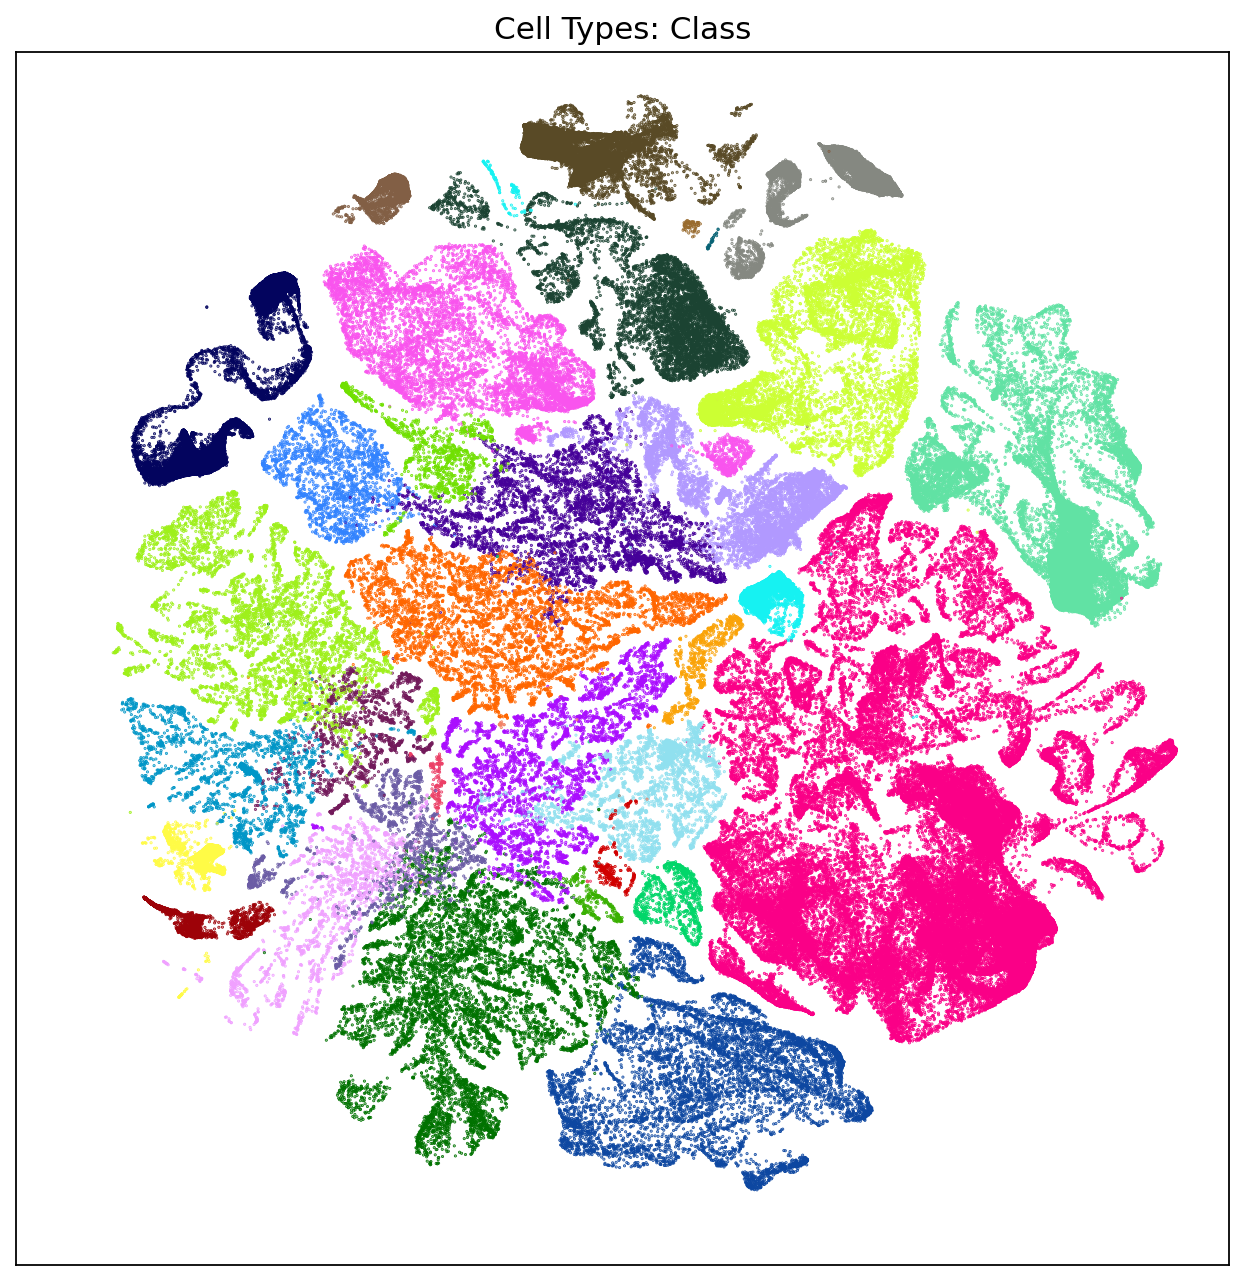

In [46]:
fig, ax = plot_umap(
    cell_subsampled["x"], cell_subsampled["y"], cc=cell_subsampled["class_color"]
)
res = ax.set_title("Cell Types: Class")
plt.show()

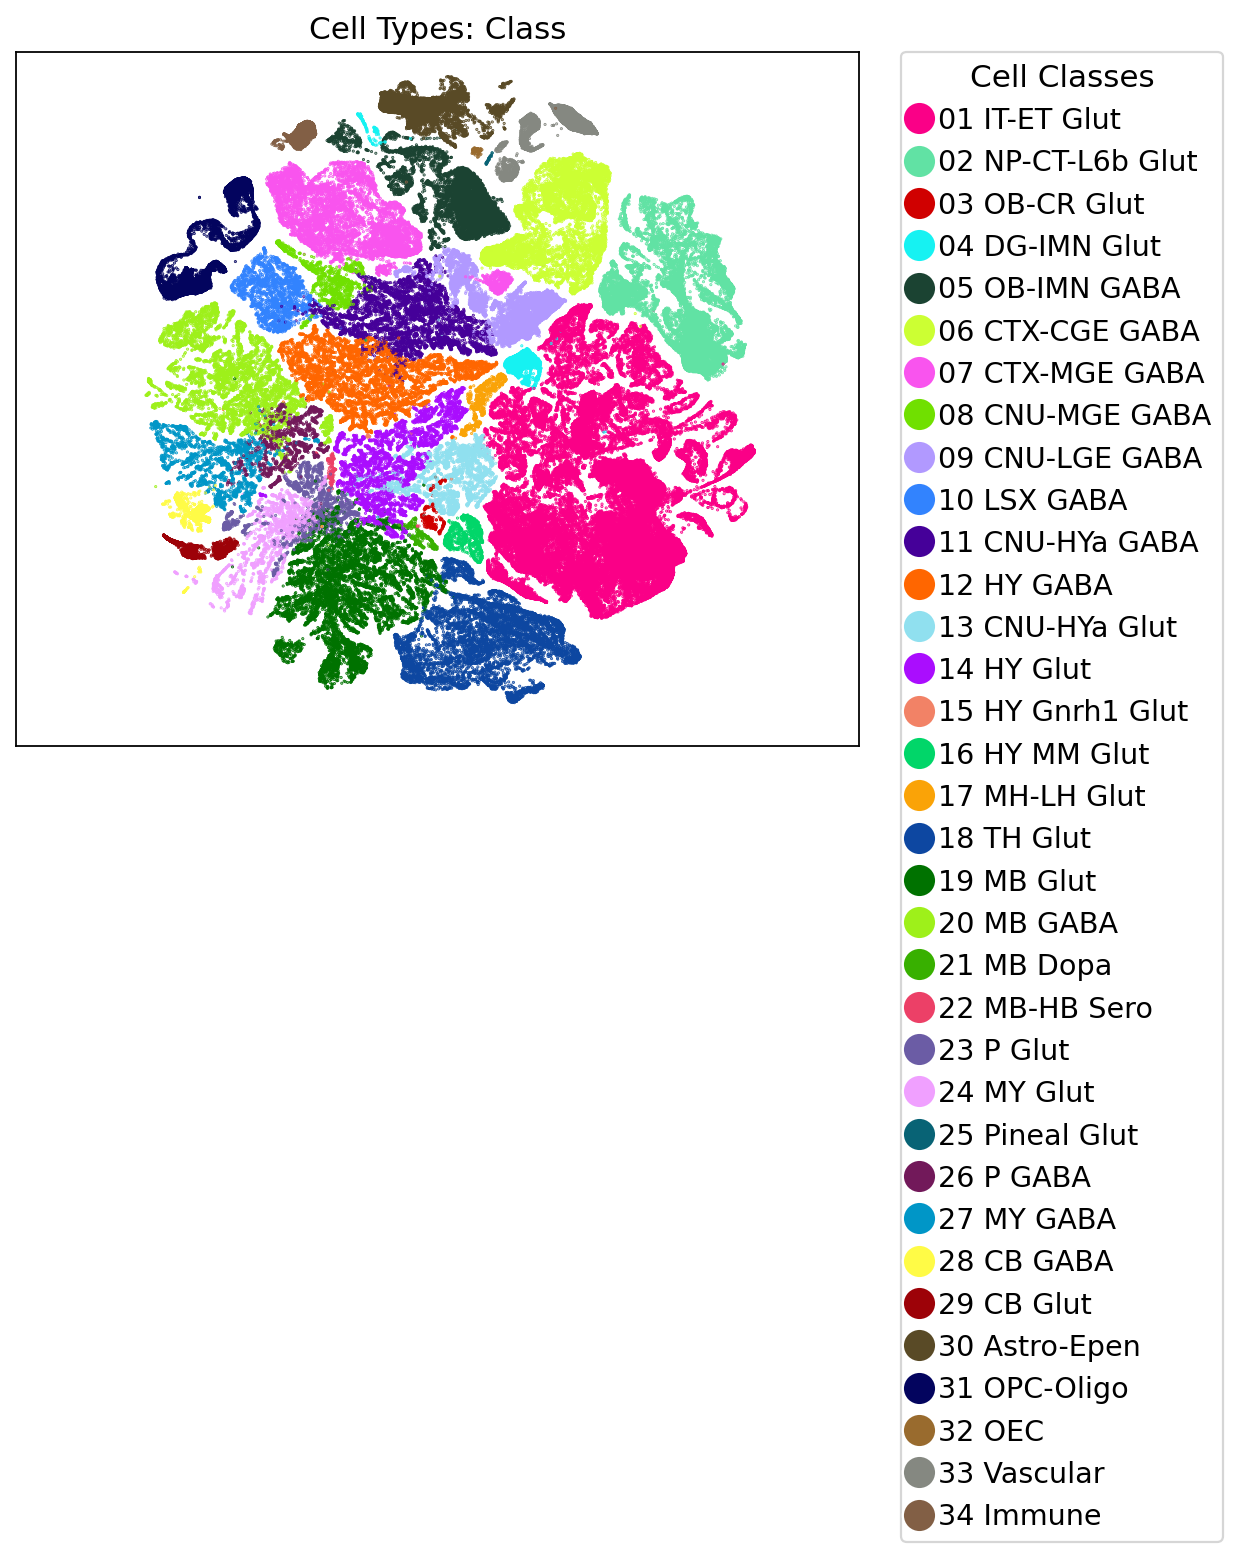

In [47]:
fig, ax = plot_umap(
    cell_subsampled["x"],
    cell_subsampled["y"],
    cc=cell_subsampled["class_color"],
    legend_classes=cell_subsampled["class"],
)
res = ax.set_title("Cell Types: Class")
plt.show()

# Load matrices

## 10Xv2

### Merge adatas

In [9]:
data_dir_10Xv2 = os.path.join(
    abc_download_dir,
    "expression_matrices",
    "WMB-10Xv2",
    "20230630",
)
data_dir_10Xv2

'/home/data/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/raw-downloaded/expression_matrices/WMB-10Xv2/20230630'

In [10]:
x = os.listdir(data_dir_10Xv2)
x = [file for file in x if "raw.h5ad" in file]
x

['WMB-10Xv2-HY-raw.h5ad',
 'WMB-10Xv2-TH-raw.h5ad',
 'WMB-10Xv2-Isocortex-1-raw.h5ad',
 'WMB-10Xv2-HPF-raw.h5ad',
 'WMB-10Xv2-Isocortex-3-raw.h5ad',
 'WMB-10Xv2-OLF-raw.h5ad',
 'WMB-10Xv2-CTXsp-raw.h5ad',
 'WMB-10Xv2-Isocortex-4-raw.h5ad',
 'WMB-10Xv2-Isocortex-2-raw.h5ad',
 'WMB-10Xv2-MB-raw.h5ad']

In [11]:
# load all samples as adata into dict (keys=samplename, values=adata objects)
adatas = {p.split(".")[0]: sc.read_h5ad(os.path.join(data_dir_10Xv2, p)) for p in x}

In [12]:
keys = list(adatas.keys())
keys

['WMB-10Xv2-HY-raw',
 'WMB-10Xv2-TH-raw',
 'WMB-10Xv2-Isocortex-1-raw',
 'WMB-10Xv2-HPF-raw',
 'WMB-10Xv2-Isocortex-3-raw',
 'WMB-10Xv2-OLF-raw',
 'WMB-10Xv2-CTXsp-raw',
 'WMB-10Xv2-Isocortex-4-raw',
 'WMB-10Xv2-Isocortex-2-raw',
 'WMB-10Xv2-MB-raw']

In [13]:
for key in adatas.keys():
    adatas[key].obs["key"] = key

In [14]:
for key in adatas.keys():
    adatas[key].obs.index.name = None

In [15]:
# for key in adatas.keys():
#    adatas[key].obs.index =adatas[key].obs.index + "_" + adatas[key].obs["anatomical_division_label"].astype(str)

In [16]:
adatas[keys[1]].obs.head()

cell_barcode       library_label  \
CAGGTGCAGGCTAGCA-040_C01  CAGGTGCAGGCTAGCA  L8TX_180815_01_E08   
TGCGCAGGTTGCGCAC-045_C01  TGCGCAGGTTGCGCAC  L8TX_180829_01_C10   
CGATGTATCTTGCCGT-042_B01  CGATGTATCTTGCCGT  L8TX_180829_01_B09   
GACTAACGTCCTCTTG-040_B01  GACTAACGTCCTCTTG  L8TX_180815_01_D08   
GATCGTACAACTGCTA-040_B01  GATCGTACAACTGCTA  L8TX_180815_01_D08   

                         anatomical_division_label               key  
CAGGTGCAGGCTAGCA-040_C01                        TH  WMB-10Xv2-TH-raw  
TGCGCAGGTTGCGCAC-045_C01                        TH  WMB-10Xv2-TH-raw  
CGATGTATCTTGCCGT-042_B01                        TH  WMB-10Xv2-TH-raw  
GACTAACGTCCTCTTG-040_B01                        TH  WMB-10Xv2-TH-raw  
GATCGTACAACTGCTA-040_B01                        TH  WMB-10Xv2-TH-raw

In [17]:
# format var
for key in adatas.keys():
    adatas[key].var["gene_identifier"] = adatas[key].var.index
    adatas[key].var.index = adatas[key].var["gene_symbol"]
    del adatas[key].var["gene_symbol"]

In [18]:
for key in adatas.keys():
    adatas[key].var_names_make_unique()

In [19]:
adatas[key].var.head()

gene_identifier
gene_symbol                    
Xkr4         ENSMUSG00000051951
Gm1992       ENSMUSG00000089699
Gm19938      ENSMUSG00000102331
Gm37381      ENSMUSG00000102343
Rp1          ENSMUSG00000025900

In [20]:
sys.getsizeof(adatas) / 1e9  # GB

3.6e-07

In [21]:
# Merge

In [22]:
merged_v2 = ad.concat(
    adatas, axis=0, join="outer", merge="first"
)  # axis=0 -> concatenate cells while genes are merged

In [23]:
merged_v2

AnnData object with n_obs × n_vars = 1708157 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'key'
    var: 'gene_identifier'

In [24]:
merged_v2.obs.index.duplicated().sum()

np.int64(0)

In [25]:
sys.getsizeof(merged_v2) / 1e9  # GB

83.77443095

In [26]:
del adatas
del x
del keys

In [ ]:
# save
merged_v2.write(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v2.h5ad.gz",
    ),
    compression="gzip",
)

In [ ]:
del merged_v2

In [9]:
# load
setdate = "20250128"  # raw
adata = sc.read_h5ad(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_v2.h5ad.gz",
    )
)

In [10]:
adata.obs.drop(
    ["cell_barcode", "library_label", "anatomical_division_label"], axis=1, inplace=True
)

### Add cell metadata
sample and cell type

In [11]:
# load formatted metadata
setdate = "20250115"
setdate = "20250411" # updated cell labels
cell_meta = pd.read_csv(
    os.path.join(
        data_dir, "misc", "scRNAseq_ref_ABCAtlas_Yao2023Nature", setdate + "_meta_data_formatted.csv.gz"
    ),
    index_col=0,
    dtype=str,
)
cell_meta = cell_meta.astype("category")
cell_meta.head(2)

class                subclass  \
GCGAGAAGTTAAGGGC-410_B05  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
AATGGCTCAGCTCCTT-411_B06  01 IT-ET Glut  018 L2 IT PPP-APr Glut   

                         neurotransmitter library_method cell_type_dea  \
GCGAGAAGTTAAGGGC-410_B05             Glut          10Xv3  Neurons-Glut   
AATGGCTCAGCTCCTT-411_B06             Glut          10Xv3  Neurons-Glut   

                         donor_id  
GCGAGAAGTTAAGGGC-410_B05   550850  
AATGGCTCAGCTCCTT-411_B06   550851

In [12]:
cell_meta.shape

(4042976, 6)

In [13]:
cell_meta["cell_type_dea"].value_counts(normalize=True)

Neurons-Glut                0.509387
Neurons-Gaba                0.205753
Oligodendrocytes            0.104521
Astrocytes                  0.074000
OPCs                        0.030325
ECs                         0.021769
Microglia                   0.021329
Neurons-Glyc-Gaba           0.009521
Pericytes                   0.006161
SMCs                        0.003615
Neurons-Granule-Immature    0.003155
VLMCs                       0.002252
Neurons-Other               0.001400
BAMs                        0.001392
Neurons-Dopa-Gaba           0.001337
Neurons-Dopa                0.001064
Ependymal                   0.000840
Bergmann                    0.000821
Astroependymal              0.000305
OECs                        0.000280
Tanycytes                   0.000265
ABCs                        0.000212
Immune-Other                0.000179
Choroid-Plexus              0.000118
Name: cell_type_dea, dtype: float64

In [14]:
adata.obs.head(2)

key
CGGGTCAGTTAGTGGG-059_E01  WMB-10Xv2-MB-raw
CGCGTTTGTCTAGGTT-067_B01  WMB-10Xv2-MB-raw

In [15]:
adata.obs.shape

(1708157, 1)

In [16]:
adata.obs = adata.obs.join(cell_meta, how="left")

In [17]:
del cell_meta

In [18]:
adata.obs.shape

(1708157, 7)

In [19]:
adata.obs.head(2)

key       class  \
CGGGTCAGTTAGTGGG-059_E01  WMB-10Xv2-MB-raw  20 MB GABA   
CGCGTTTGTCTAGGTT-067_B01  WMB-10Xv2-MB-raw  19 MB Glut   

                                           subclass neurotransmitter  \
CGGGTCAGTTAGTGGG-059_E01  205 SC-PAG Lef1 Emx2 Gaba             GABA   
CGCGTTTGTCTAGGTT-067_B01        187 SCsg Pde5a Glut             Glut   

                         library_method cell_type_dea donor_id  
CGGGTCAGTTAGTGGG-059_E01          10Xv2  Neurons-Gaba   414907  
CGCGTTTGTCTAGGTT-067_B01          10Xv2  Neurons-Glut   423499

Note: Some cells contain basic metadata but no cell type annotation. Possibly low quality? Drop those not in metadata. 

In [20]:
adata.obs.index.duplicated().sum()

0

In [21]:
adata.obs.isnull().sum(axis=0)

key                      0
class                 8218
subclass              8218
neurotransmitter    101486
library_method        8218
cell_type_dea         8218
donor_id              8218
dtype: int64

In [22]:
missing_in_meta = adata.obs["donor_id"].isnull()

In [23]:
adata.obs[missing_in_meta].key.value_counts()

WMB-10Xv2-OLF-raw            1541
WMB-10Xv2-Isocortex-1-raw    1264
WMB-10Xv2-Isocortex-4-raw    1256
WMB-10Xv2-HPF-raw            1018
WMB-10Xv2-Isocortex-3-raw     684
WMB-10Xv2-HY-raw              683
WMB-10Xv2-Isocortex-2-raw     680
WMB-10Xv2-TH-raw              657
WMB-10Xv2-CTXsp-raw           325
WMB-10Xv2-MB-raw              110
Name: key, dtype: int64

In [24]:
#adata = adata[~missing_in_meta].copy()

In [25]:
#adata._inplace_subset_obs(~missing_in_meta)

In [26]:
adata = adata[~missing_in_meta]

In [27]:
adata.shape

(1699939, 32285)

In [28]:
adata.obs.head(2)

key       class  \
CGGGTCAGTTAGTGGG-059_E01  WMB-10Xv2-MB-raw  20 MB GABA   
CGCGTTTGTCTAGGTT-067_B01  WMB-10Xv2-MB-raw  19 MB Glut   

                                           subclass neurotransmitter  \
CGGGTCAGTTAGTGGG-059_E01  205 SC-PAG Lef1 Emx2 Gaba             GABA   
CGCGTTTGTCTAGGTT-067_B01        187 SCsg Pde5a Glut             Glut   

                         library_method cell_type_dea donor_id  
CGGGTCAGTTAGTGGG-059_E01          10Xv2  Neurons-Gaba   414907  
CGCGTTTGTCTAGGTT-067_B01          10Xv2  Neurons-Glut   423499

In [29]:
adata

View of AnnData object with n_obs × n_vars = 1699939 × 32285
    obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
    var: 'gene_identifier'

### Add gene metadata
Contains no additional information

### Export ECs

For additional annotation of EC zonation (separate script)

In [29]:
adata_vascular = adata[
    adata.obs["cell_type_dea"].isin(["Pericytes", "ECs", "VLMCs", "ABCs", "SMCs"])
].copy()

In [ ]:
adata_vascular

In [ ]:
# save
adata_vascular.write(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v2_vascular_subset.h5ad.gz",
    ),
    compression="gzip",
)

In [ ]:
del adata_vascular

### Pseudobulking

In [32]:
adata.X

<1699939x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 6911812740 stored elements in Compressed Sparse Row format>

In [34]:
# check that .X contains raw counts
adata.X.max()

4303.0

In [30]:
adata.obs.head(2)

key       class  \
CGGGTCAGTTAGTGGG-059_E01  WMB-10Xv2-MB-raw  20 MB GABA   
CGCGTTTGTCTAGGTT-067_B01  WMB-10Xv2-MB-raw  19 MB Glut   

                                           subclass neurotransmitter  \
CGGGTCAGTTAGTGGG-059_E01  205 SC-PAG Lef1 Emx2 Gaba             GABA   
CGCGTTTGTCTAGGTT-067_B01        187 SCsg Pde5a Glut             Glut   

                         library_method cell_type_dea donor_id  
CGGGTCAGTTAGTGGG-059_E01          10Xv2  Neurons-Gaba   414907  
CGCGTTTGTCTAGGTT-067_B01          10Xv2  Neurons-Glut   423499

In [31]:
# number of cells per group
adata.obs["cell_type_dea"].value_counts()

Neurons-Glut                1272934
Neurons-Gaba                 327872
Oligodendrocytes              51363
OPCs                          16146
Astrocytes                    12282
Microglia                      4760
ECs                            3655
Neurons-Dopa-Gaba              3069
Neurons-Granule-Immature       3066
Pericytes                      1737
SMCs                            909
VLMCs                           560
Neurons-Other                   465
OECs                            433
Ependymal                       191
BAMs                            110
Immune-Other                     71
Tanycytes                        68
Neurons-Glyc-Gaba                66
Neurons-Dopa                     62
Astroependymal                   58
ABCs                             33
Choroid-Plexus                   29
Name: cell_type_dea, dtype: int64

In [32]:
# number of samples per group
for cell_type in adata.obs["cell_type_dea"].cat.categories:
    unique_donors = len(
        adata[adata.obs["cell_type_dea"] == cell_type].obs["donor_id"].cat.categories
    )
    print(f"{unique_donors} {cell_type}")

18 ABCs
95 Astrocytes
13 Astroependymal
26 BAMs
4 Choroid-Plexus
94 ECs
14 Ependymal
27 Immune-Other
93 Microglia
9 Neurons-Dopa
48 Neurons-Dopa-Gaba
96 Neurons-Gaba
96 Neurons-Glut
15 Neurons-Glyc-Gaba
32 Neurons-Granule-Immature
8 Neurons-Other
6 OECs
93 OPCs
96 Oligodendrocytes
88 Pericytes
77 SMCs
4 Tanycytes
75 VLMCs


In [33]:
combined_values = adata.obs["cell_type_dea"].astype(str) + "_" + adata.obs["donor_id"].astype(str)
adata.obs["celltypedea_donorid"] = pd.Categorical(combined_values)
del combined_values

In [34]:
#adata.obs["celltypedea_donorid"] = adata.obs.apply(
#    lambda row: f"{row['cell_type_dea']}_{row['donor_id']}", axis=1
#)

In [35]:
# add number of cells per cell_type-sample group
adata.obs["n_cells"] = adata.obs.groupby(["cell_type_dea", "donor_id"])[
    "donor_id"
].transform("count")

In [36]:
adata.obs[:2]

key       class  \
CGGGTCAGTTAGTGGG-059_E01  WMB-10Xv2-MB-raw  20 MB GABA   
CGCGTTTGTCTAGGTT-067_B01  WMB-10Xv2-MB-raw  19 MB Glut   

                                           subclass neurotransmitter  \
CGGGTCAGTTAGTGGG-059_E01  205 SC-PAG Lef1 Emx2 Gaba             GABA   
CGCGTTTGTCTAGGTT-067_B01        187 SCsg Pde5a Glut             Glut   

                         library_method cell_type_dea donor_id  \
CGGGTCAGTTAGTGGG-059_E01          10Xv2  Neurons-Gaba   414907   
CGCGTTTGTCTAGGTT-067_B01          10Xv2  Neurons-Glut   423499   

                          celltypedea_donorid  n_cells  
CGGGTCAGTTAGTGGG-059_E01  Neurons-Gaba_414907     6096  
CGCGTTTGTCTAGGTT-067_B01  Neurons-Glut_423499     2230

In [37]:
ncells = adata.obs.groupby(["cell_type_dea", "donor_id"])["n_cells"].count()
ncells = pd.DataFrame(ncells)

In [38]:
# pd.set_option('display.max_rows', None)
# ncells
# pd.set_option('display.max_rows', 15)

In [39]:
# clean up the cell type names to avoid Python to R conversion issues
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("/", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("+", "") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("(", "") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(")", "") for ct in adata.obs["cell_type_dea"]]

In [40]:
# set categorical metadata to be indeed categorical to create pseudobulks
adata.obs["donor_id"] = adata.obs["donor_id"].astype("category")
adata.obs["cell_type_dea"] = adata.obs["cell_type_dea"].astype("category")
adata.obs["celltypedea_donorid"] = adata.obs["celltypedea_donorid"].astype("category")
adata.obs["n_cells"] = adata.obs["n_cells"].astype(int)

- ``pseudobulk_aggregate_and_filter`` is a function that creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than X cells for the specified population.
- by changing the ``replicates_per_patient`` parameter, several (n) pseudo-replicates can be created for each sample; cells are then split into n subsets of roughly equal sizes.

In [41]:
obs_to_keep = [
    "cell_type_dea",
    "donor_id",
    "celltypedea_donorid",
    "n_cells",
    "library_method",
]

In [42]:
# run pseudobluking
NUM_OF_CELL_PER_DONOR = (15)
start_total = time()
cell_type_i = adata.obs["cell_type_dea"].cat.categories[0]
print(
    f"Processing {cell_type_i} (1 out of {len(adata.obs['cell_type_dea'].cat.categories)})..."
)
adata_pb = pseudobulk_aggregate_and_filter(
    adata=adata,
    cell_identity=cell_type_i,
    cell_identity_key="cell_type_dea",
    donor_key="donor_id",
    obs_to_keep=obs_to_keep,
)
for i, cell_type_i in enumerate(adata.obs["cell_type_dea"].cat.categories[1:]):
    print(
        f"Processing {cell_type_i} ({i + 2} out of {len(adata.obs['cell_type_dea'].cat.categories)})..."
    )
    adata_cell_type = pseudobulk_aggregate_and_filter(
        adata=adata,
        cell_identity=cell_type_i,
        cell_identity_key="cell_type_dea",
        donor_key="donor_id",
        obs_to_keep=obs_to_keep,
    )
    adata_pb = adata_pb.concatenate(adata_cell_type)
print(f"Total time: {(time() - start_total) / 60:.1f}m")

Processing ABCs (1 out of 23)...
Dropping the following samples:
['352353', '352357', '366676', '380340', '380345', '381293', '381295', '412866', '414905', '414906', '421226', '425676', '441865', '443005', '443636', '443644', '446701', '446714']
	Processing donor 18 out of 18...

Processing Astrocytes (2 out of 23)...
Dropping the following samples:
['355877', '365616', '366292', '373314', '374159', '374166', '385670', '392473', '396975', '407901', '407902', '410110', '414899', '414901', '426004', '434997', '435849', '439976', '525798']
	Processing donor 95 out of 95...

Processing Astroependymal (3 out of 23)...
Dropping the following samples:
['374165', '381917', '404122', '404123', '404125', '407902', '407905', '414907', '421227', '425676', '449635', '529270', '529272']
	Processing donor 13 out of 13...

Processing BAMs (4 out of 23)...
Dropping the following samples:
['352353', '352356', '366678', '374165', '380340', '381293', '395345', '404123', '404124', '404125', '407905', '4101

In [43]:
adata_pb.obs_names = adata_pb.obs["celltypedea_donorid"]
adata_pb.obs["n_cells"] = adata_pb.obs["n_cells"].astype(int)

In [44]:
adata_pb

AnnData object with n_obs × n_vars = 644 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch'

In [45]:
pd.crosstab(adata_pb.obs["cell_type_dea"], adata_pb.obs["batch"])

batch                      0   1
cell_type_dea                   
Astrocytes                76   0
BAMs                       2   0
Choroid-Plexus             1   0
ECs                       61   0
Ependymal                  5   0
Immune-Other               1   0
Microglia                 53   0
Neurons-Dopa-Gaba         11   0
Neurons-Gaba              96   0
Neurons-Glut              96   0
Neurons-Glyc-Gaba          1   0
Neurons-Granule-Immature   9   0
Neurons-Other              5   0
OECs                       3   0
OPCs                      79   0
Oligodendrocytes          93   0
Pericytes                 28   0
SMCs                      11   0
Tanycytes                  2   0
VLMCs                      0  11

### Explore Covariates
on PCA

In [46]:
adata_pb.layers["counts"] = adata_pb.X.copy()
adata_pb.layers["log1p_norm"] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6, layer="log1p_norm")
sc.pp.log1p(adata_pb, layer="log1p_norm")
adata_pb.X = adata_pb.layers["log1p_norm"]

In [47]:
adata_pb.layers

Layers with keys: counts, log1p_norm

In [48]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(np.float64))

In [49]:
adata_pb.obs.head(2)

cell_type_dea donor_id celltypedea_donorid  n_cells  \
celltypedea_donorid                                                       
Astrocytes_352353      Astrocytes   352353   Astrocytes_352353      142   
Astrocytes_352356      Astrocytes   352356   Astrocytes_352356      174   

                    library_method batch  lib_size  log_lib_size  
celltypedea_donorid                                               
Astrocytes_352353            10Xv2     0  434153.0     12.981152  
Astrocytes_352356            10Xv2     0  608173.0     13.318215

In [50]:
sc.pp.pca(adata_pb)

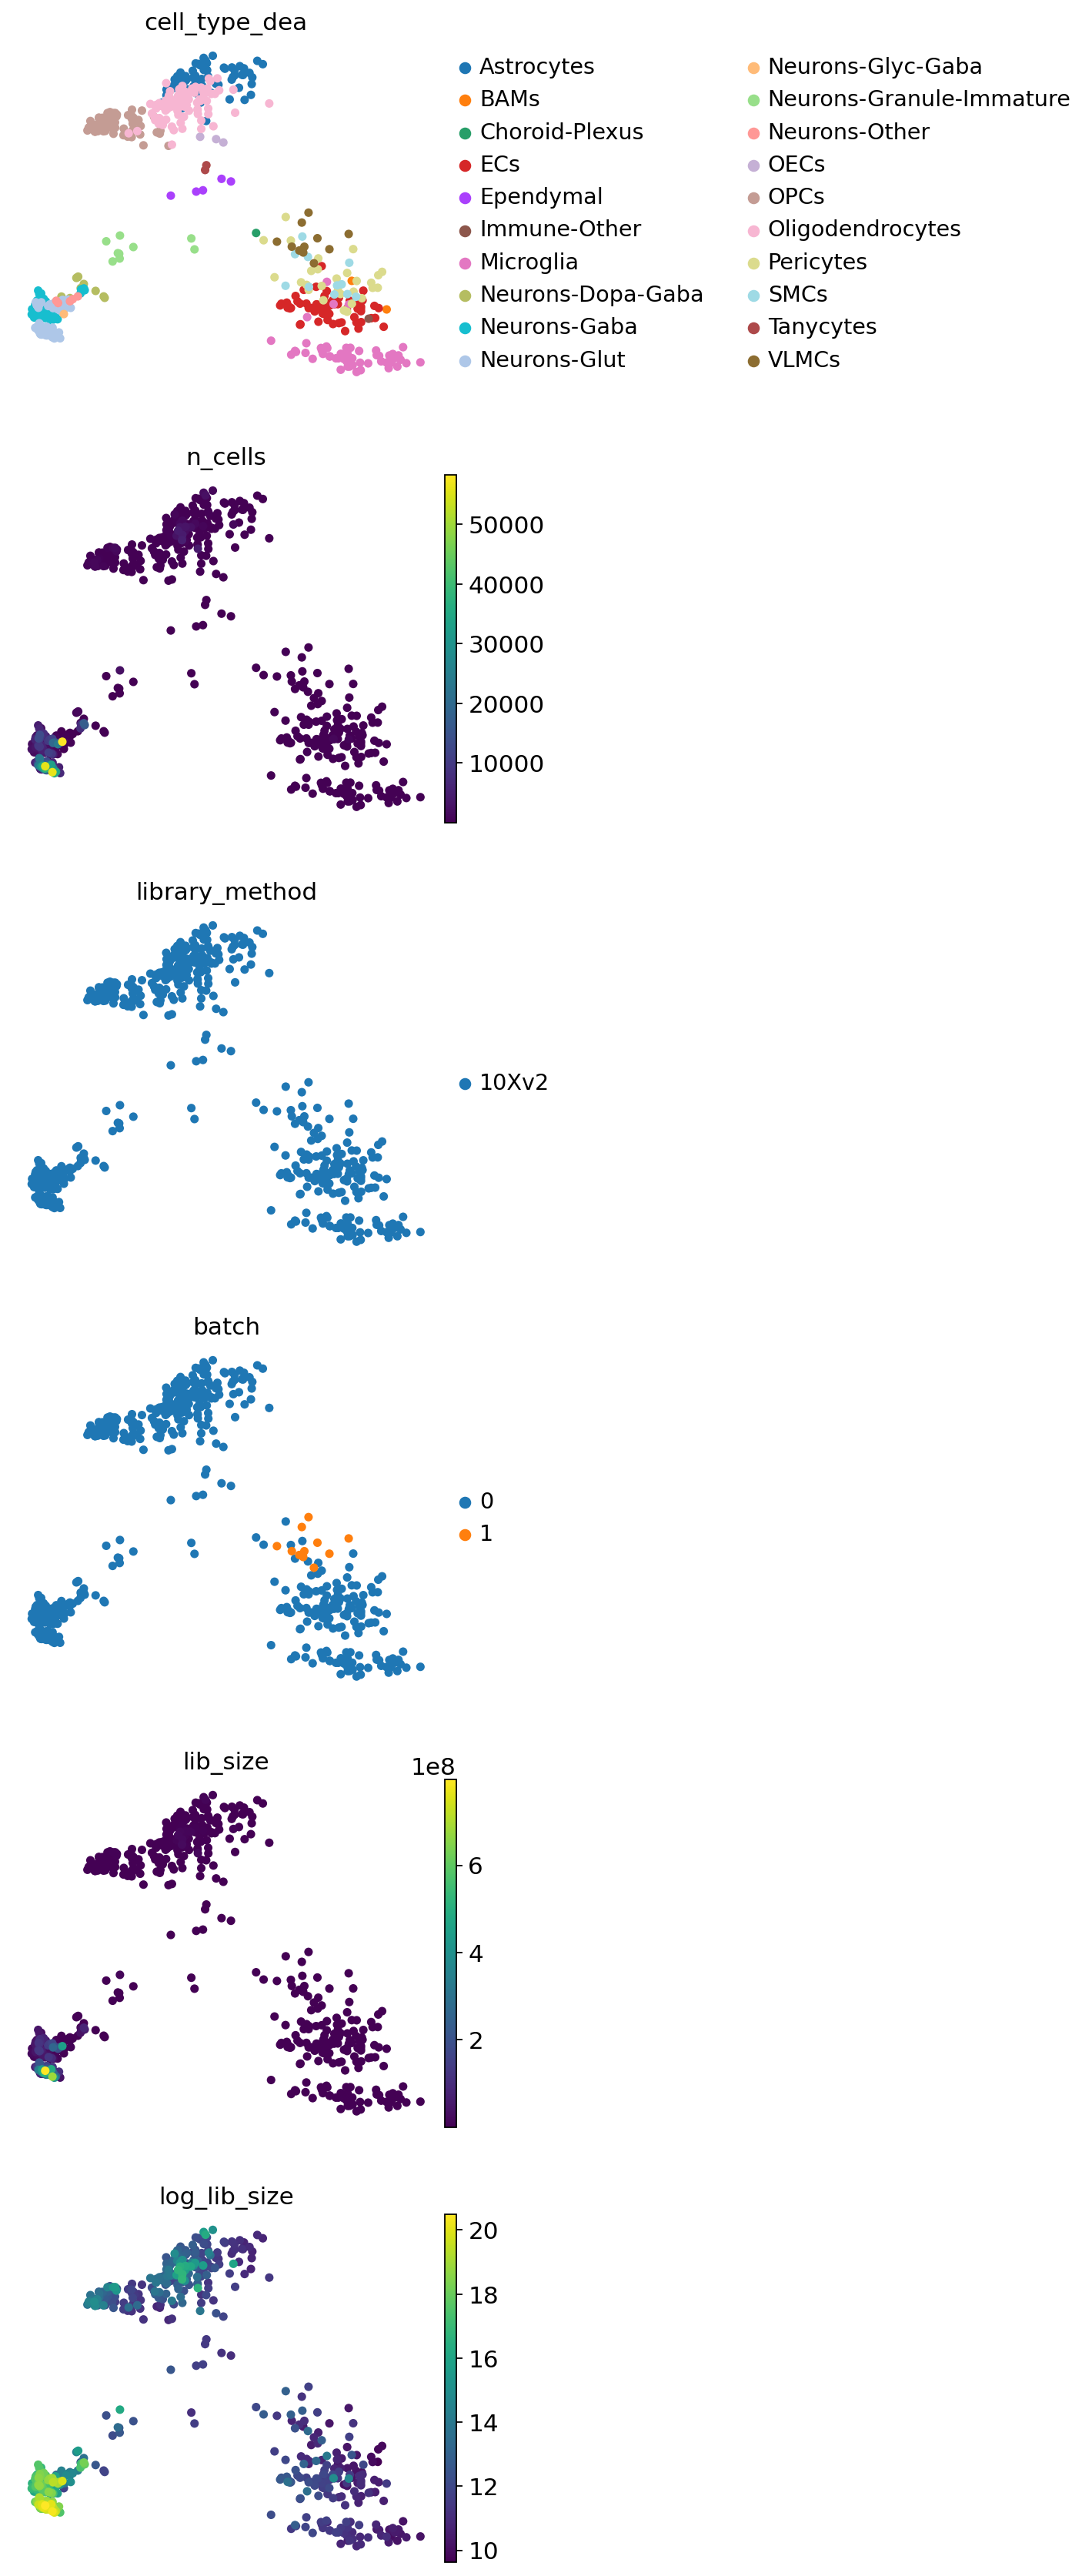

In [51]:
sc.pl.pca(
    adata_pb,
    color=adata_pb.obs.drop(columns=["celltypedea_donorid", "donor_id"]),
    ncols=1,
    size=100,
)

In [52]:
adata_pb.X = adata_pb.layers["counts"].copy()

In [53]:
del adata_pb.layers

In [54]:
# del adata_pb.uns['donor_id_colors']
del adata_pb.uns["cell_type_dea_colors"]
del adata_pb.uns["batch_colors"]

In [55]:
adata_pb

AnnData object with n_obs × n_vars = 644 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'library_method_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [56]:
# for compatibility
adata_pb.obs["lib_size"] = adata_pb.obs["lib_size"].astype(int)
adata_pb.obs["celltypedea_donorid"] = adata_pb.obs["celltypedea_donorid"].astype(
    "category"
)
adata_pb.obs.index = adata_pb.obs["celltypedea_donorid"]

In [57]:
adata_pb.obs.dtypes

cell_type_dea          category
donor_id               category
celltypedea_donorid    category
n_cells                   int64
library_method         category
batch                  category
lib_size                  int64
log_lib_size            float64
dtype: object

In [58]:
adata_pb.X = scipy.sparse.csr_matrix(adata_pb.X, dtype="float32")

In [59]:
adata_pb.X

<644x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 9815904 stored elements in Compressed Sparse Row format>

In [60]:
# save
adata_pb.write(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v2_pseudobulks.h5ad.gz",
    ),
    compression="gzip",
)

In [61]:
# load
setdate = "20250129"  # raw counts, pseudobulks
setdate = "20250411"  # raw counts, pseudobulks, updated cell types
adata = sc.read_h5ad(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_v2_pseudobulks.h5ad.gz",
    )
)

In [62]:
adata

AnnData object with n_obs × n_vars = 644 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'library_method_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [63]:
adata.X.max()

21642372.0

In [64]:
del adata
del adata_pb

## 10Xv3

### Merge adatas

In [8]:
data_dir_10Xv3 = os.path.join(
    abc_download_dir,
    "expression_matrices",
    "WMB-10Xv3",
    "20230630",
)
data_dir_10Xv3

'/home/data/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/raw-downloaded/expression_matrices/WMB-10Xv3/20230630'

In [9]:
x = os.listdir(data_dir_10Xv3)
x = [file for file in x if "raw.h5ad" in file]
x

['WMB-10Xv3-CB-raw.h5ad',
 'WMB-10Xv3-P-raw.h5ad',
 'WMB-10Xv3-CTXsp-raw.h5ad',
 'WMB-10Xv3-HY-raw.h5ad',
 'WMB-10Xv3-Isocortex-2-raw.h5ad',
 'WMB-10Xv3-MB-raw.h5ad',
 'WMB-10Xv3-PAL-raw.h5ad',
 'WMB-10Xv3-HPF-raw.h5ad',
 'WMB-10Xv3-Isocortex-1-raw.h5ad',
 'WMB-10Xv3-STR-raw.h5ad',
 'WMB-10Xv3-TH-raw.h5ad',
 'WMB-10Xv3-OLF-raw.h5ad',
 'WMB-10Xv3-MY-raw.h5ad']

In [ ]:
# load all samples as adata into dict (keys=samplename, values=adata objects)
adatas = {p.split(".")[0]: sc.read_h5ad(os.path.join(data_dir_10Xv3, p)) for p in x}

In [ ]:
keys = list(adatas.keys())
keys

In [16]:
for key in adatas.keys():
    adatas[key].obs["key"] = key

In [17]:
for key in adatas.keys():
    adatas[key].obs.index.name = None

In [18]:
# for key in adatas.keys():
#    adatas[key].obs.index =adatas[key].obs.index + "_" + adatas[key].obs["anatomical_division_label"].astype(str)

In [19]:
adatas[keys[1]].obs.head()

cell_barcode       library_label  \
GCCCGAAGTCAGTTTG-344_C04  GCCCGAAGTCAGTTTG  L8TX_200827_01_E10   
AGGTTACTCGCGCCAA-332_B01  AGGTTACTCGCGCCAA  L8TX_200820_01_D01   
ATGAGGGAGTGTTCCA-332_A01  ATGAGGGAGTGTTCCA  L8TX_200820_01_E02   
CATAGACAGTCTAACC-299_B02  CATAGACAGTCTAACC  L8TX_200723_01_G09   
GAGTTACCATGACGAG-299_A02  GAGTTACCATGACGAG  L8TX_200723_01_F09   

                         anatomical_division_label                  key  
GCCCGAAGTCAGTTTG-344_C04                     CTXsp  WMB-10Xv3-CTXsp-raw  
AGGTTACTCGCGCCAA-332_B01                     CTXsp  WMB-10Xv3-CTXsp-raw  
ATGAGGGAGTGTTCCA-332_A01                     CTXsp  WMB-10Xv3-CTXsp-raw  
CATAGACAGTCTAACC-299_B02                     CTXsp  WMB-10Xv3-CTXsp-raw  
GAGTTACCATGACGAG-299_A02                     CTXsp  WMB-10Xv3-CTXsp-raw

In [20]:
# format var
for key in adatas.keys():
    adatas[key].var["gene_identifier"] = adatas[key].var.index
    adatas[key].var.index = adatas[key].var["gene_symbol"]
    del adatas[key].var["gene_symbol"]

In [21]:
for key in adatas.keys():
    adatas[key].var_names_make_unique()

In [22]:
adatas[key].var.head()

gene_identifier
gene_symbol                    
Xkr4         ENSMUSG00000051951
Gm1992       ENSMUSG00000089699
Gm19938      ENSMUSG00000102331
Gm37381      ENSMUSG00000102343
Rp1          ENSMUSG00000025900

In [23]:
sys.getsizeof(adatas) / 1e9  # GB

6.4e-07

In [24]:
# Merge

In [25]:
merged_v3 = ad.concat(
    adatas, axis=0, join="outer", merge="first"
)  # axis=0 -> concatenate cells while genes are merged

In [26]:
merged_v3

AnnData object with n_obs × n_vars = 2349544 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'key'
    var: 'gene_identifier'

In [27]:
merged_v3.obs.index.duplicated().sum()

0

In [28]:
sys.getsizeof(merged_v3) / 1e9  # GB

142.113155675

In [29]:
del adatas
del x
del keys

In [30]:
merged_v3.write(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v3.h5ad.gz",
    ),
    compression="gzip",
)

In [31]:
del merged_v3

In [9]:
# load
setdate = "20250129"  # raw
adata = sc.read_h5ad(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_v3.h5ad.gz",
    )
)

In [10]:
adata.obs.drop(
    ["cell_barcode", "library_label", "anatomical_division_label"], axis=1, inplace=True
)

In [11]:
adata

AnnData object with n_obs × n_vars = 2349544 × 32285
    obs: 'key'
    var: 'gene_identifier'

### Add cell metadata
sample and cell type

In [12]:
# load formatted metadata
setdate = "20250115"
setdate = "20250411" # updated cell labels
cell_meta = pd.read_csv(
    os.path.join(
        data_dir, "misc", "scRNAseq_ref_ABCAtlas_Yao2023Nature", setdate + "_meta_data_formatted.csv.gz"
    ),
    index_col=0,
    dtype=str,
)
cell_meta = cell_meta.astype("category")
cell_meta.head(2)

class                subclass  \
GCGAGAAGTTAAGGGC-410_B05  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
AATGGCTCAGCTCCTT-411_B06  01 IT-ET Glut  018 L2 IT PPP-APr Glut   

                         neurotransmitter library_method cell_type_dea  \
GCGAGAAGTTAAGGGC-410_B05             Glut          10Xv3  Neurons-Glut   
AATGGCTCAGCTCCTT-411_B06             Glut          10Xv3  Neurons-Glut   

                         donor_id  
GCGAGAAGTTAAGGGC-410_B05   550850  
AATGGCTCAGCTCCTT-411_B06   550851

In [13]:
adata.obs.head(2)

key
TGAGGGACACCAAATC-392_A04  WMB-10Xv3-HY-raw
AACGGGAGTACGTGAG-469_A03  WMB-10Xv3-HY-raw

In [14]:
adata.obs.shape

(2349544, 1)

In [15]:
adata.obs = adata.obs.join(cell_meta, how="left")

In [16]:
adata.obs.shape

(2349544, 7)

In [17]:
adata.obs.head(2)

key            class  \
TGAGGGACACCAAATC-392_A04  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   
AACGGGAGTACGTGAG-469_A03  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   

                                               subclass neurotransmitter  \
TGAGGGACACCAAATC-392_A04  079 CEA-BST Six3 Cyp26b1 Gaba             GABA   
AACGGGAGTACGTGAG-469_A03  079 CEA-BST Six3 Cyp26b1 Gaba             GABA   

                         library_method cell_type_dea donor_id  
TGAGGGACACCAAATC-392_A04          10Xv3  Neurons-Gaba   546895  
AACGGGAGTACGTGAG-469_A03          10Xv3  Neurons-Gaba   556848

In [18]:
# split adata to manage memory
# ensuring all cells from the same donor (donor_id) stay in the same group

In [19]:
donors = adata.obs["donor_id"].unique()
len(donors)

223

In [20]:
n_splits = 6

In [21]:
def split_adata(adata, n_splits=n_splits):
    groups = {i: [] for i in range(n_splits)}
    for i, donor in enumerate(donors):
        groups[i % n_splits].append(donor)
    return [adata[adata.obs["donor_id"].isin(groups[i])] for i in range(n_splits)]


adatas = split_adata(adata)

In [22]:
adatas

[View of AnnData object with n_obs × n_vars = 406825 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 View of AnnData object with n_obs × n_vars = 374334 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 View of AnnData object with n_obs × n_vars = 427456 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 View of AnnData object with n_obs × n_vars = 375452 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 View of AnnData object with n_obs × n_vars = 378609 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 View of AnnData object with n

In [23]:
del adata

Note: Some cells contain basic metadata but no cell type annotation. Possibly low quality? Drop those not in metadata. 

In [24]:
for i in range(n_splits):
    print(adatas[i].obs.index.duplicated().sum())

0
0
0
0
0
0


In [25]:
for i in range(n_splits):
    print(i)
    print(adatas[i].obs.isnull().sum(axis=0))

0
key                      0
class                    0
subclass                 0
neurotransmitter    186310
library_method           0
cell_type_dea            0
donor_id                 0
dtype: int64
1
key                      0
class                    0
subclass                 0
neurotransmitter    166929
library_method           0
cell_type_dea            0
donor_id                 0
dtype: int64
2
key                      0
class                    0
subclass                 0
neurotransmitter    198776
library_method           0
cell_type_dea            0
donor_id                 0
dtype: int64
3
key                      0
class                 8194
subclass              8194
neurotransmitter    174624
library_method        8194
cell_type_dea         8194
donor_id              8194
dtype: int64
4
key                      0
class                    0
subclass                 0
neurotransmitter    114982
library_method           0
cell_type_dea            0
donor_id            

In [26]:
for i in range(n_splits):
    print(i)
    missing_in_meta = adatas[i].obs["donor_id"].isnull()
    print(adatas[i].obs[missing_in_meta].key.value_counts())
    adatas[i] = adatas[i][~missing_in_meta].copy()

0
WMB-10Xv3-CB-raw             0
WMB-10Xv3-CTXsp-raw          0
WMB-10Xv3-HPF-raw            0
WMB-10Xv3-HY-raw             0
WMB-10Xv3-Isocortex-1-raw    0
WMB-10Xv3-Isocortex-2-raw    0
WMB-10Xv3-MB-raw             0
WMB-10Xv3-MY-raw             0
WMB-10Xv3-OLF-raw            0
WMB-10Xv3-P-raw              0
WMB-10Xv3-PAL-raw            0
WMB-10Xv3-STR-raw            0
WMB-10Xv3-TH-raw             0
Name: key, dtype: int64
1
WMB-10Xv3-CB-raw             0
WMB-10Xv3-CTXsp-raw          0
WMB-10Xv3-HPF-raw            0
WMB-10Xv3-HY-raw             0
WMB-10Xv3-Isocortex-1-raw    0
WMB-10Xv3-Isocortex-2-raw    0
WMB-10Xv3-MB-raw             0
WMB-10Xv3-MY-raw             0
WMB-10Xv3-OLF-raw            0
WMB-10Xv3-P-raw              0
WMB-10Xv3-PAL-raw            0
WMB-10Xv3-STR-raw            0
WMB-10Xv3-TH-raw             0
Name: key, dtype: int64
2
WMB-10Xv3-CB-raw             0
WMB-10Xv3-CTXsp-raw          0
WMB-10Xv3-HPF-raw            0
WMB-10Xv3-HY-raw             0
WMB-10Xv3-Isocor

In [27]:
adatas

[AnnData object with n_obs × n_vars = 406825 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 AnnData object with n_obs × n_vars = 374334 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 AnnData object with n_obs × n_vars = 427456 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 AnnData object with n_obs × n_vars = 367258 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 AnnData object with n_obs × n_vars = 378609 × 32285
     obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
     var: 'gene_identifier',
 AnnData object with n_obs × n_vars = 386868 × 32285
     obs: 'key', 

In [28]:
del cell_meta

### Add gene metadata
No additional information

In [29]:
# gene_meta.head(2)

In [30]:
# adata.var.head(2)

In [31]:
# adata.var.join(gene_meta, how="left")

In [32]:
# adata.var.head(2)

### Export ECs

For additional annotation of EC zonation (separate script)

In [35]:
filtered_adatas = {}

In [36]:
for i in range(n_splits):
    filtered_adatas[i] = adatas[i][
        adatas[i]
        .obs["cell_type_dea"]
        .isin(["Pericytes", "ECs", "VLMCs", "ABCs", "SMCs"])
    ].copy()

In [37]:
adata_merged = sc.concat(list(filtered_adatas.values()))

In [39]:
adata_merged

AnnData object with n_obs × n_vars = 130599 × 32285
    obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'

In [40]:
adata_merged.obs.cell_type_dea.value_counts()

ECs          84356
Pericytes    23170
SMCs         13705
VLMCs         8544
ABCs           824
Name: cell_type_dea, dtype: int64

In [41]:
# save
adata_merged.write(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v3_vascular_subset.h5ad.gz",
    ),
    compression="gzip",
)

In [42]:
del adata_merged
del filtered_adatas

### Pseudobulking

In [35]:
adatas[i].X

<386868x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 1963287548 stored elements in Compressed Sparse Row format>

In [36]:
# check that .X contains raw counts
for i in range(n_splits):
    print(adatas[i].X.max())

16928.0
34575.0
10250.0
11869.0
14814.0
15060.0


In [33]:
adatas[i].obs.head(2)

key            class  \
TACCTGCAGTTCCTGA-354_A06  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   
AACCTTTGTAACTGCT-354_C06  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   

                                               subclass neurotransmitter  \
TACCTGCAGTTCCTGA-354_A06  080 CEA-AAA-BST Six3 Sp9 Gaba             GABA   
AACCTTTGTAACTGCT-354_C06  080 CEA-AAA-BST Six3 Sp9 Gaba             GABA   

                         library_method cell_type_dea donor_id  
TACCTGCAGTTCCTGA-354_A06          10Xv3  Neurons-Gaba   540230  
AACCTTTGTAACTGCT-354_C06          10Xv3  Neurons-Gaba   540230

In [34]:
# number of cells per group
for i in range(n_splits):
    print(i)
    print(adatas[i].obs["cell_type_dea"].value_counts())

0
Neurons-Glut                117694
Neurons-Gaba                 92459
Oligodendrocytes             62915
Astrocytes                   57961
OPCs                         19193
ECs                          17666
Microglia                    14682
Neurons-Glyc-Gaba             6176
Pericytes                     4773
SMCs                          2797
Neurons-Granule-Immature      2154
VLMCs                         1975
BAMs                          1207
Ependymal                     1118
Neurons-Other                 1094
Neurons-Dopa                   811
Neurons-Dopa-Gaba              701
Astroependymal                 392
ABCs                           289
Bergmann                       280
Tanycytes                      205
Immune-Other                   155
Choroid-Plexus                  84
OECs                            44
Name: cell_type_dea, dtype: int64
1
Neurons-Glut                116545
Neurons-Gaba                 85243
Oligodendrocytes             61790
Astrocytes       

In [35]:
# number of samples per group
for i in range(n_splits):
    print(i)
    for cell_type in adatas[i].obs["cell_type_dea"].cat.categories:
        unique_donors = len(
            adatas[i][adatas[i].obs["cell_type_dea"] == cell_type]
            .obs["donor_id"]
            .cat.categories
        )
        print(f"{unique_donors} {cell_type}")

0
10 ABCs
38 Astrocytes
15 Astroependymal
30 BAMs
4 Bergmann
5 Choroid-Plexus
38 ECs
20 Ependymal
26 Immune-Other
37 Microglia
8 Neurons-Dopa
10 Neurons-Dopa-Gaba
38 Neurons-Gaba
38 Neurons-Glut
17 Neurons-Glyc-Gaba
12 Neurons-Granule-Immature
20 Neurons-Other
1 OECs
38 OPCs
38 Oligodendrocytes
36 Pericytes
35 SMCs
6 Tanycytes
36 VLMCs
1
10 ABCs
37 Astrocytes
11 Astroependymal
28 BAMs
5 Bergmann
4 Choroid-Plexus
37 ECs
19 Ependymal
20 Immune-Other
37 Microglia
7 Neurons-Dopa
11 Neurons-Dopa-Gaba
37 Neurons-Gaba
37 Neurons-Glut
14 Neurons-Glyc-Gaba
10 Neurons-Granule-Immature
21 Neurons-Other
2 OECs
37 OPCs
37 Oligodendrocytes
34 Pericytes
34 SMCs
4 Tanycytes
29 VLMCs
2
13 ABCs
37 Astrocytes
11 Astroependymal
30 BAMs
3 Bergmann
5 Choroid-Plexus
36 ECs
14 Ependymal
20 Immune-Other
36 Microglia
8 Neurons-Dopa
9 Neurons-Dopa-Gaba
35 Neurons-Gaba
37 Neurons-Glut
15 Neurons-Glyc-Gaba
13 Neurons-Granule-Immature
17 Neurons-Other
1 OECs
37 OPCs
37 Oligodendrocytes
36 Pericytes
31 SMCs
3 Tanycy

In [36]:
# add number of cells per cell_type-sample group
for i in range(n_splits):
    adatas[i].obs["n_cells"] = (
        adatas[i]
        .obs.groupby(["cell_type_dea", "donor_id"])["donor_id"]
        .transform("count")
    )

In [37]:
adatas[i].obs[:2]

key            class  \
TACCTGCAGTTCCTGA-354_A06  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   
AACCTTTGTAACTGCT-354_C06  WMB-10Xv3-HY-raw  11 CNU-HYa GABA   

                                               subclass neurotransmitter  \
TACCTGCAGTTCCTGA-354_A06  080 CEA-AAA-BST Six3 Sp9 Gaba             GABA   
AACCTTTGTAACTGCT-354_C06  080 CEA-AAA-BST Six3 Sp9 Gaba             GABA   

                         library_method cell_type_dea donor_id  n_cells  
TACCTGCAGTTCCTGA-354_A06          10Xv3  Neurons-Gaba   540230     5514  
AACCTTTGTAACTGCT-354_C06          10Xv3  Neurons-Gaba   540230     5514

In [38]:
ncells = adatas[i].obs.groupby(["cell_type_dea", "donor_id"])["n_cells"].count()
ncells = pd.DataFrame(ncells)

In [39]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_rows', 15)

In [40]:
ncells

n_cells
cell_type_dea donor_id         
ABCs          426001          0
              450095          0
              457909          0
              464328          0
              468425          0
...                         ...
VLMCs         565914         31
              574606         82
              574607         26
              604611          1
              621073         40

[888 rows x 1 columns]

In [41]:
# clean up the cell type names to avoid Python to R conversion issues
for i in range(n_splits):
    adatas[i].obs["cell_type_dea"] = [
        ct.replace(" ", "_") for ct in adatas[i].obs["cell_type_dea"]
    ]
    adatas[i].obs["cell_type_dea"] = [
        ct.replace("/", "_") for ct in adatas[i].obs["cell_type_dea"]
    ]
    adatas[i].obs["cell_type_dea"] = [
        ct.replace(" ", "_") for ct in adatas[i].obs["cell_type_dea"]
    ]
    adatas[i].obs["cell_type_dea"] = [
        ct.replace("+", "") for ct in adatas[i].obs["cell_type_dea"]
    ]
    adatas[i].obs["cell_type_dea"] = [
        ct.replace("(", "") for ct in adatas[i].obs["cell_type_dea"]
    ]
    adatas[i].obs["cell_type_dea"] = [
        ct.replace(")", "") for ct in adatas[i].obs["cell_type_dea"]
    ]

In [42]:
# set categorical metadata to be indeed categorical to create pseudobulks
for i in range(n_splits):
    adatas[i].obs["donor_id"] = adatas[i].obs["donor_id"].astype("category")
    adatas[i].obs["cell_type_dea"] = adatas[i].obs["cell_type_dea"].astype("category")
    adatas[i].obs["n_cells"] = adatas[i].obs["n_cells"].astype(int)

- ``pseudobulk_aggregate_and_filter`` is a function that creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than X cells for the specified population.
- by changing the ``replicates_per_patient`` parameter, several (n) pseudo-replicates can be created for each sample; cells are then split into n subsets of roughly equal sizes.

In [43]:
obs_to_keep = [
    "cell_type_dea",
    "donor_id",
    "n_cells",
    "library_method",
]  # , "celltypedea_donorid"

In [44]:
NUM_OF_CELL_PER_DONOR = (
    15  # cell_type-sample combinations must have more cells to not get excluded
)

In [45]:
def process_split(adata_split, obs_to_keep=obs_to_keep):
    adata_pb_split = None

    for j, cell_type_i in enumerate(adata_split.obs["cell_type_dea"].cat.categories):
        print(
            f"Processing {cell_type_i} ({j + 1} out of {len(adata_split.obs['cell_type_dea'].cat.categories)})"
        )

        adata_cell_type = pseudobulk_aggregate_and_filter(
            adata=adata_split,
            cell_identity=cell_type_i,
            cell_identity_key="cell_type_dea",
            donor_key="donor_id",
            obs_to_keep=obs_to_keep,
        )

        if adata_pb_split is None:
            adata_pb_split = adata_cell_type
        else:
            adata_pb_split = adata_pb_split.concatenate(adata_cell_type)

        del adata_cell_type

    return adata_pb_split

In [46]:
start_total = time()
for i, adata_split in enumerate(adatas):
    # for i, adata_split in enumerate(adatas[4:], start=4): # Starting from i = 4 manually
    print(f"Processing split {i + 1} out of {len(adatas)}...")
    adata_pb_split = process_split(adata_split, obs_to_keep)
    adata_pb_split.X = scipy.sparse.csr_matrix(adata_pb_split.X, dtype="float32")
    adata_pb_split.obs["n_cells"] = adata_pb_split.obs["n_cells"].astype(int)
    output_path = os.path.join(
        data_dir,"misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        f"{date.today().strftime('%Y%m%d')}_merged_v3_pseudobulks_split_{i}.h5ad.gz",
    )
    adata_pb_split.write(output_path, compression="gzip")
    del adata_pb_split
print(f"Total time: {(time() - start_total) / 60:.1f}m")

Processing split 1 out of 6...
Processing ABCs (1 out of 24)
Dropping the following samples:
['546811', '550850', '553680', '554922', '556113', '562458', '565824']
	Processing donor 10 out of 10...

Processing Astrocytes (2 out of 24)
Dropping the following samples:
['462433', '531163']
	Processing donor 38 out of 38...

Processing Astroependymal (3 out of 24)
Dropping the following samples:
['473085', '473981', '482568', '529271', '549927', '553680', '554815', '561536', '565915', '572421']
	Processing donor 15 out of 15...

Processing BAMs (4 out of 24)
Dropping the following samples:
['473981', '482568', '494814', '505950', '511243', '561536', '563792', '565824', '608856']
	Processing donor 30 out of 30...

Processing Bergmann (5 out of 24)
Dropping the following samples:
['556113', '572421']
	Processing donor 4 out of 4...

Processing Choroid-Plexus (6 out of 24)
Dropping the following samples:
['554815', '554919', '565915']
	Processing donor 5 out of 5...

Processing ECs (7 out of 

In [47]:
del adatas

In [48]:
# load splits
setdate = "20250129"
setdate = "20250411" # updated cell labels
files = sorted(
    glob(
        os.path.join(
            data_dir, "misc",
            "scRNAseq_ref_ABCAtlas_Yao2023Nature",
            "anndata-objects",
            f"{setdate}_merged_v3_pseudobulks_split_*.h5ad.gz",
        )
    )
)

In [49]:
files

['/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250411_merged_v3_pseudobulks_split_0.h5ad.gz',
 '/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250411_merged_v3_pseudobulks_split_1.h5ad.gz',
 '/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250411_merged_v3_pseudobulks_split_2.h5ad.gz',
 '/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250411_merged_v3_pseudobulks_split_3.h5ad.gz',
 '/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250411_merged_v3_pseudobulks_split_4.h5ad.gz',
 '/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250411_merged_v3_pseudobulks_split_5.h5ad.gz']

In [50]:
# merge splits
adata_merged = sc.concat([sc.read_h5ad(f) for f in files])

In [51]:
adata_merged

AnnData object with n_obs × n_vars = 2095 × 32285
    obs: 'cell_type_dea', 'donor_id', 'n_cells', 'library_method', 'batch'

In [52]:
len(adata_merged.obs["donor_id"].unique())

222

In [53]:
import scipy.sparse

adata_merged.X = scipy.sparse.csr_matrix(adata_merged.X, dtype="float32")

In [54]:
adata_merged.X

<2095x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 38325545 stored elements in Compressed Sparse Row format>

In [55]:
adata_merged.X.max()

13331419.0

In [56]:
adata_merged.obs.dtypes

cell_type_dea     category
donor_id          category
n_cells              int64
library_method    category
batch             category
dtype: object

In [57]:
# save merged
adata_merged.write(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v3_pseudobulks_temp.h5ad.gz",
    ),
    compression="gzip",
)

In [58]:
# load merged
setdate = "20250129" # raw temp
setdate = "20250411" # raw temp, updated cell labels
adata_merged = sc.read_h5ad(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_v3_pseudobulks_temp.h5ad.gz",
    )
)

In [59]:
adata_merged

AnnData object with n_obs × n_vars = 2095 × 32285
    obs: 'cell_type_dea', 'donor_id', 'n_cells', 'library_method', 'batch'

In [60]:
# Delete temp split files
! rm "$data_dir"/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250411_merged_v3_pseudobulks_split_[0-9]*.h5ad.gz

In [61]:
adata_pb = adata_merged.copy()

In [62]:
del adata_merged

In [63]:
adata_pb.obs["celltypedea_donorid"] = adata_pb.obs.apply(
    lambda row: f"{row['cell_type_dea']}_{row['donor_id']}", axis=1
)
adata_pb.obs["celltypedea_donorid"] = adata_pb.obs["celltypedea_donorid"].astype(
    "category"
)

In [64]:
adata_pb.obs_names = adata_pb.obs["celltypedea_donorid"]
adata_pb.obs["n_cells"] = adata_pb.obs["n_cells"].astype(int)

In [65]:
adata_pb

AnnData object with n_obs × n_vars = 2095 × 32285
    obs: 'cell_type_dea', 'donor_id', 'n_cells', 'library_method', 'batch', 'celltypedea_donorid'

In [66]:
pd.crosstab(adata_pb.obs["cell_type_dea"], adata_pb.obs["batch"])

batch                       0    1
cell_type_dea                     
ABCs                       15    0
Astrocytes                208    0
Astroependymal             20    0
BAMs                       93    0
Bergmann                   15    0
Choroid-Plexus              7    0
ECs                       151    0
Ependymal                  27    0
Immune-Other                5    0
Microglia                 133    0
Neurons-Dopa               21    0
Neurons-Dopa-Gaba          20    0
Neurons-Gaba              197    0
Neurons-Glut              221    0
Neurons-Glyc-Gaba          81    0
Neurons-Granule-Immature   43    0
Neurons-Other              59    0
OECs                        8    0
OPCs                      217    0
Oligodendrocytes          222    0
Pericytes                 113    0
SMCs                      102    0
Tanycytes                  12    0
VLMCs                       0  105

### Explore Covariates
on PCA

In [67]:
adata_pb.layers["counts"] = adata_pb.X.copy()
adata_pb.layers["log1p_norm"] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6, layer="log1p_norm")
sc.pp.log1p(adata_pb, layer="log1p_norm")
adata_pb.X = adata_pb.layers["log1p_norm"]

In [68]:
adata_pb.layers

Layers with keys: counts, log1p_norm

In [69]:
adata_pb.X.max()

11.94506

In [70]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(np.float64))

In [71]:
adata_pb.obs.head(2)

cell_type_dea donor_id  n_cells library_method batch  \
celltypedea_donorid                                                        
ABCs_546813                  ABCs   546813      109          10Xv3     0   
ABCs_548212                  ABCs   548212      130          10Xv3     0   

                    celltypedea_donorid   lib_size  log_lib_size  
celltypedea_donorid                                               
ABCs_546813                 ABCs_546813  1523589.0     14.236579  
ABCs_548212                 ABCs_548212  2175399.0     14.592723

In [72]:
sc.pp.pca(adata_pb)

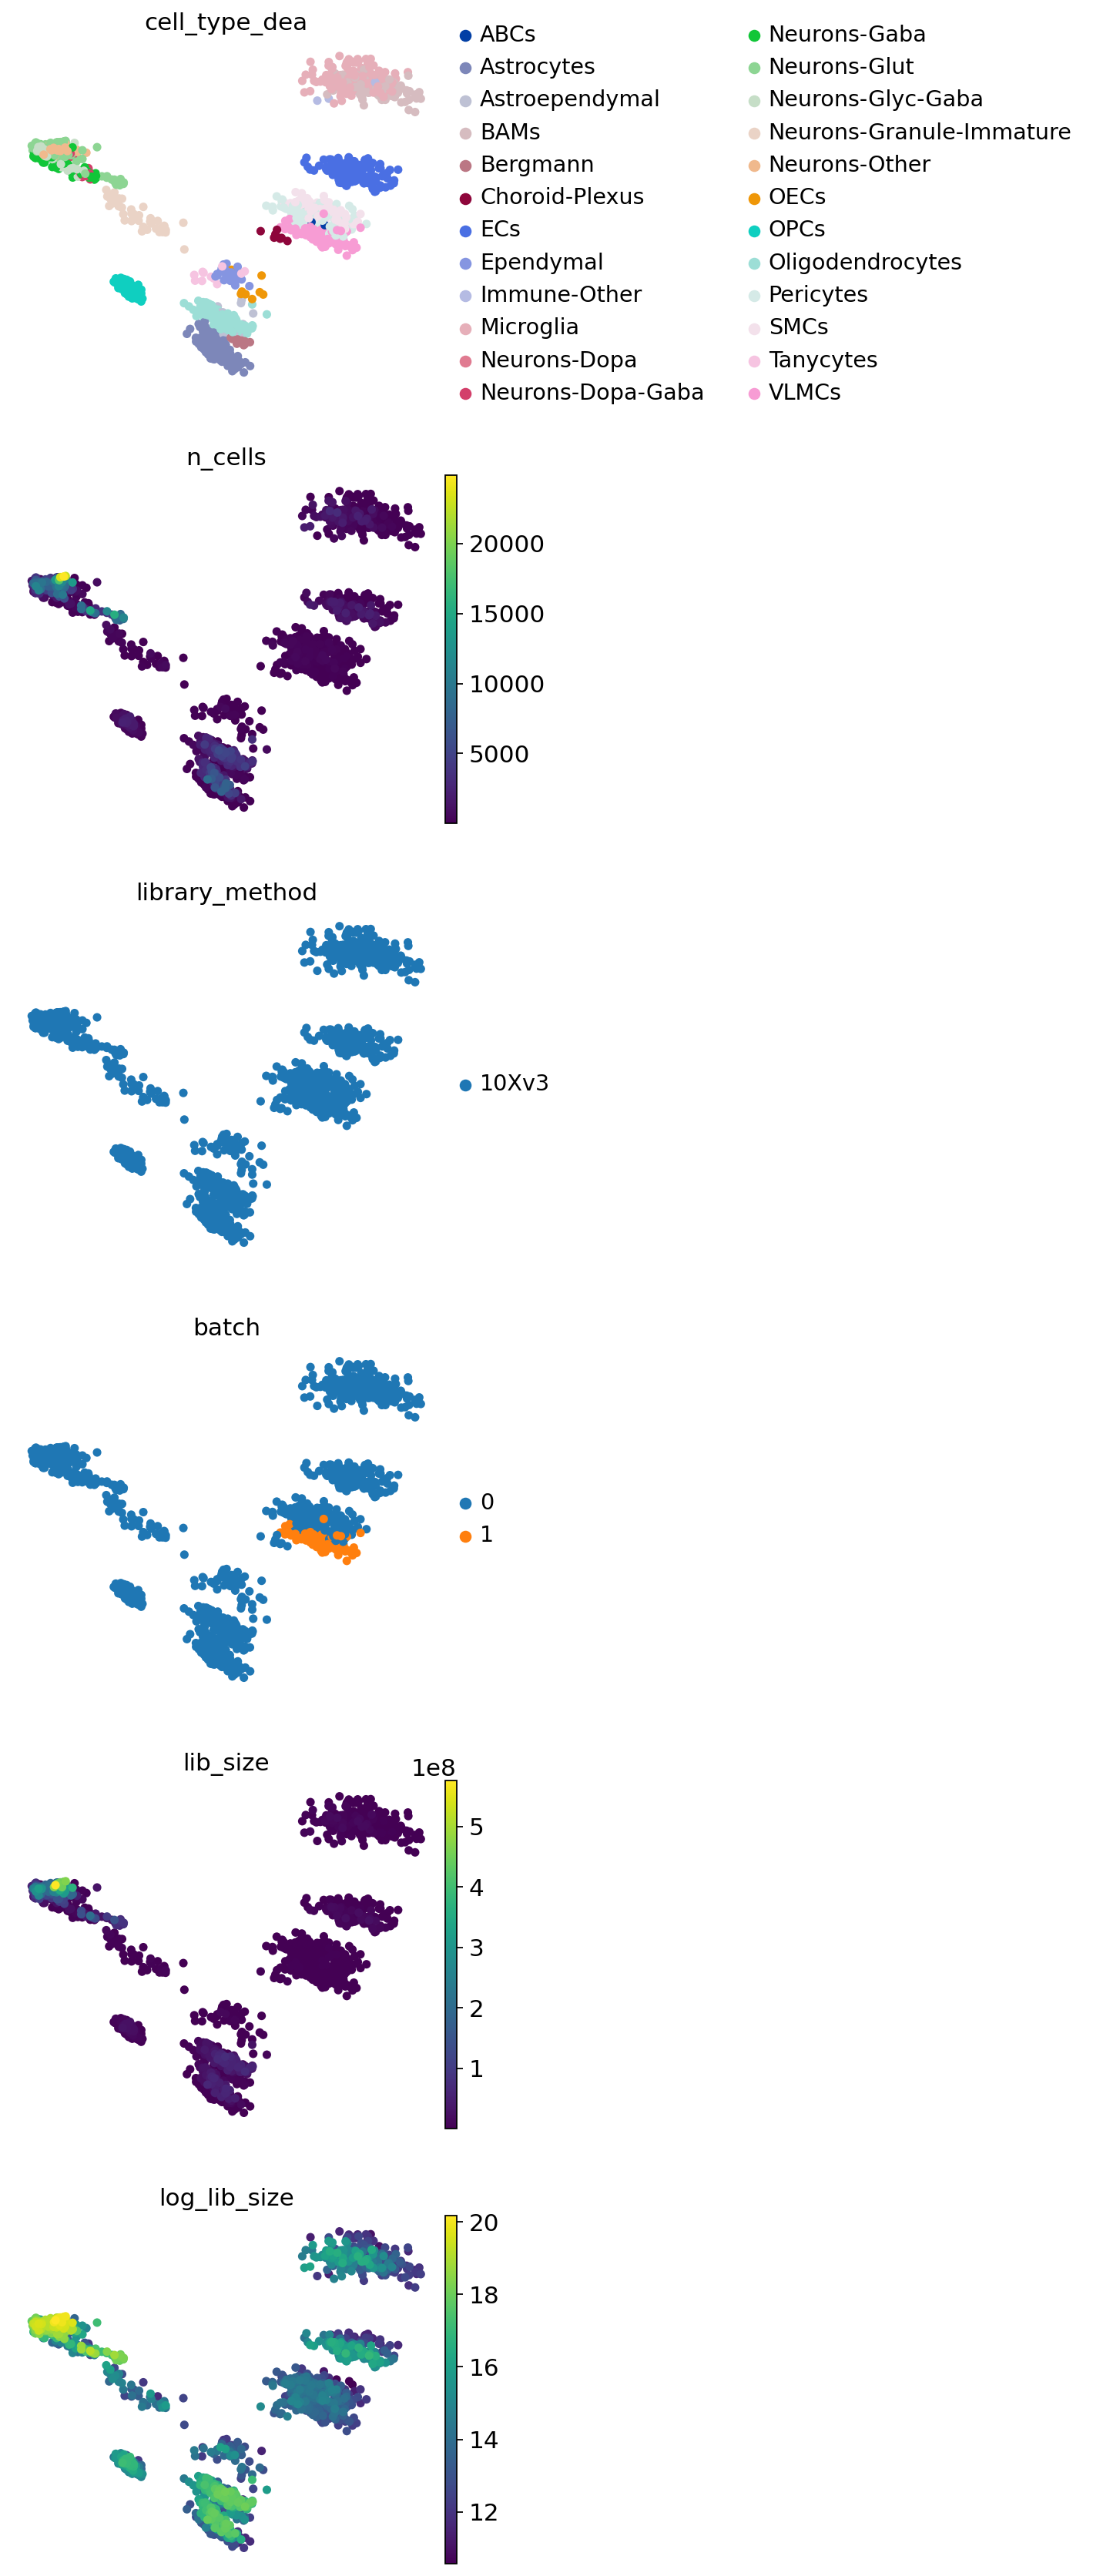

In [73]:
sc.pl.pca(
    adata_pb,
    color=adata_pb.obs.drop(columns=["celltypedea_donorid", "donor_id"]),
    ncols=1,
    size=100,
)

In [74]:
adata_pb.X = adata_pb.layers["counts"].copy()

In [75]:
del adata_pb.layers

In [76]:
del adata_pb.uns["cell_type_dea_colors"]
del adata_pb.uns["batch_colors"]

In [77]:
adata_pb

AnnData object with n_obs × n_vars = 2095 × 32285
    obs: 'cell_type_dea', 'donor_id', 'n_cells', 'library_method', 'batch', 'celltypedea_donorid', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'library_method_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [78]:
adata_pb.X.max()

13331419.0

In [79]:
# for compatibility
adata_pb.obs["lib_size"] = adata_pb.obs["lib_size"].astype(int)
adata_pb.obs["celltypedea_donorid"] = adata_pb.obs["celltypedea_donorid"].astype(
    "category"
)
adata_pb.obs.index = adata_pb.obs["celltypedea_donorid"]

In [80]:
adata_pb.obs.dtypes

cell_type_dea          category
donor_id               category
n_cells                   int64
library_method         category
batch                  category
celltypedea_donorid    category
lib_size                  int64
log_lib_size            float64
dtype: object

In [81]:
os.path.join(
   data_dir, "misc",
    "scRNAseq_ref_ABCAtlas_Yao2023Nature",
    "anndata-objects",
    date.today().strftime("%Y%m%d") + "_merged_v3_pseudobulks.h5ad.gz",
)

'/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250411_merged_v3_pseudobulks.h5ad.gz'

In [82]:
# save
adata_pb.write(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_v3_pseudobulks.h5ad.gz",
    ),  #
    compression="gzip",
)

In [83]:
# load
setdate = "20250129"  # raw counts, pseudobulks
setdate = "20250411" # raw counts, pseudobulks, updated cell labels
adata = sc.read_h5ad(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_v3_pseudobulks.h5ad.gz",
    )
)

In [84]:
adata

AnnData object with n_obs × n_vars = 2095 × 32285
    obs: 'cell_type_dea', 'donor_id', 'n_cells', 'library_method', 'batch', 'celltypedea_donorid', 'lib_size', 'log_lib_size'
    uns: 'library_method_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [85]:
adata.X.max()

13331419.0

## 10XMulti

Single file only

In [9]:
data_dir_10XMulti = os.path.join(
    abc_download_dir,
    "expression_matrices",
    "WMB-10XMulti",
    "20230830",
)
data_dir_10XMulti

'/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/raw-downloaded/expression_matrices/WMB-10XMulti/20230830'

In [10]:
x = os.listdir(data_dir_10XMulti)
x = [file for file in x if "raw.h5ad" in file]
x

['WMB-10XMulti-raw.h5ad']

In [11]:
# load all samples as adata into dict (keys=samplename, values=adata objects)
adata_10XMulti = sc.read_h5ad(os.path.join(data_dir_10XMulti, x[0]))

In [12]:
adata_10XMulti

AnnData object with n_obs × n_vars = 1687 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'

In [13]:
key = "WMB-10XMulti-raw"

In [14]:
adata_10XMulti.obs["key"] = key

In [15]:
adata_10XMulti.obs.index.name = None

In [16]:
adata_10XMulti.obs.head()

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   
AACTGTTCAGCAGGTA-1143_A05  AACTGTTCAGCAGGTA  L8XR_220317_03_H06   
AAGTTTGTCATAACTG-1143_A05  AAGTTTGTCATAACTG  L8XR_220317_03_H06   
AATTTGGTCAAACCGT-1143_A05  AATTTGGTCAAACCGT  L8XR_220317_03_H06   

                          anatomical_division_label               key  
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-raw  
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-raw  
AACTGTTCAGCAGGTA-1143_A05                        CB  WMB-10XMulti-raw  
AAGTTTGTCATAACTG-1143_A05                        CB  WMB-10XMulti-raw  
AATTTGGTCAAACCGT-1143_A05                        CB  WMB-10XMulti-raw

In [17]:
# format var
adata_10XMulti.var["gene_identifier"] = adata_10XMulti.var.index.astype("str")
adata_10XMulti.var.index = adata_10XMulti.var["gene_symbol"].astype("str")
del adata_10XMulti.var["gene_symbol"]

In [18]:
adata_10XMulti.var_names_make_unique()

In [19]:
adata_10XMulti.var.head()

gene_identifier
gene_symbol                    
Xkr4         ENSMUSG00000051951
Gm1992       ENSMUSG00000089699
Gm19938      ENSMUSG00000102331
Gm37381      ENSMUSG00000102343
Rp1          ENSMUSG00000025900

In [20]:
[gene for gene in adata_10XMulti.var_names if "Ptp4a1" in gene]

['Ptp4a1', 'Ptp4a1-1']

In [21]:
adata_10XMulti.var.dtypes

gene_identifier    object
dtype: object

In [22]:
adata_10XMulti.obs.index.duplicated().sum()

0

In [23]:
sys.getsizeof(adata_10XMulti) / 1e9  # GB

0.133725167

In [24]:
adata = adata_10XMulti.copy()

In [25]:
del adata_10XMulti

### Add cell metadata
sample and cell type

In [26]:
# load formatted metadata
setdate = "20250115"
setdate = "20250411" # updated cell labels
cell_meta = pd.read_csv(
    os.path.join(
        data_dir, "misc", "scRNAseq_ref_ABCAtlas_Yao2023Nature", setdate + "_meta_data_formatted.csv.gz"
    ),
    index_col=0,
    dtype=str,
)
cell_meta = cell_meta.astype("category")
cell_meta.head(2)

class                subclass  \
GCGAGAAGTTAAGGGC-410_B05  01 IT-ET Glut  018 L2 IT PPP-APr Glut   
AATGGCTCAGCTCCTT-411_B06  01 IT-ET Glut  018 L2 IT PPP-APr Glut   

                         neurotransmitter library_method cell_type_dea  \
GCGAGAAGTTAAGGGC-410_B05             Glut          10Xv3  Neurons-Glut   
AATGGCTCAGCTCCTT-411_B06             Glut          10Xv3  Neurons-Glut   

                         donor_id  
GCGAGAAGTTAAGGGC-410_B05   550850  
AATGGCTCAGCTCCTT-411_B06   550851

In [27]:
adata.obs.head(2)

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   

                          anatomical_division_label               key  
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-raw  
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-raw

In [28]:
adata.obs.shape

(1687, 4)

In [29]:
adata.obs = adata.obs.join(cell_meta, how="left")

In [30]:
adata.obs.shape

(1687, 10)

In [31]:
adata.obs.head(2)

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   

                          anatomical_division_label               key  \
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-raw   
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-raw   

                                class                 subclass  \
AACATCATCAGCCAAT-1143_A05  24 MY Glut  254 VCO Mafa Meis2 Glut   
AACTAGCTCCGTTAAA-1143_A05  24 MY Glut        261 HB Calcb Chol   

                          neurotransmitter library_method  cell_type_dea  \
AACATCATCAGCCAAT-1143_A05             Glut   10xRSeq_Mult   Neurons-Glut   
AACTAGCTCCGTTAAA-1143_A05             Chol   10xRSeq_Mult  Neurons-Other   

                          donor_id  
AACATCATCAGCCAAT-1143_A05   621255  
AACTAGCTCCGTTAAA-1143_A05   621255

Note: Some cells contain basic metadata but no cell type annotation. Possibly low quality? Drop those not in metadata. 

In [32]:
adata.obs.index.duplicated().sum()

0

In [33]:
adata.obs.isnull().sum(axis=0)

cell_barcode                 0
library_label                0
anatomical_division_label    0
key                          0
class                        0
subclass                     0
neurotransmitter             0
library_method               0
cell_type_dea                0
donor_id                     0
dtype: int64

In [34]:
missing_in_meta = adata.obs["donor_id"].isnull()

In [35]:
adata.obs[missing_in_meta].key.value_counts()

Series([], Name: key, dtype: int64)

In [36]:
adata = adata[~missing_in_meta]

In [37]:
adata.shape

(1687, 32285)

In [38]:
adata.obs.head(2)

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   

                          anatomical_division_label               key  \
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-raw   
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-raw   

                                class                 subclass  \
AACATCATCAGCCAAT-1143_A05  24 MY Glut  254 VCO Mafa Meis2 Glut   
AACTAGCTCCGTTAAA-1143_A05  24 MY Glut        261 HB Calcb Chol   

                          neurotransmitter library_method  cell_type_dea  \
AACATCATCAGCCAAT-1143_A05             Glut   10xRSeq_Mult   Neurons-Glut   
AACTAGCTCCGTTAAA-1143_A05             Chol   10xRSeq_Mult  Neurons-Other   

                          donor_id  
AACATCATCAGCCAAT-1143_A05   621255  
AACTAGCTCCGTTAAA-1143_A05   621255

In [39]:
adata

View of AnnData object with n_obs × n_vars = 1687 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
    var: 'gene_identifier'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'

In [40]:
del cell_meta

### Add gene metadata
No additional information

In [41]:
# gene_meta.head(2)

In [42]:
# adata.var.head(2)

In [43]:
# adata.var.join(gene_meta, how="left")

In [44]:
# adata.var.head(2)

### Export ECs

For additional annotation of EC zonation (separate script)

In [45]:
adata_vascular = adata[
    adata.obs["cell_type_dea"].isin(["Pericytes", "ECs", "VLMCs", "ABCs", "SMCs"])
].copy()

In [46]:
adata_vascular

AnnData object with n_obs × n_vars = 0 × 32285
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label', 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'
    var: 'gene_identifier'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'

Note: No vascular cells

### Pseudobulking

In [47]:
adata.X

<1687x32285 sparse matrix of type '<class 'numpy.float64'>'
	with 10725202 stored elements in Compressed Sparse Row format>

In [48]:
# check that .X contains raw counts
adata.X.max()

11779.0

In [49]:
adata.obs.head(2)

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   

                          anatomical_division_label               key  \
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-raw   
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-raw   

                                class                 subclass  \
AACATCATCAGCCAAT-1143_A05  24 MY Glut  254 VCO Mafa Meis2 Glut   
AACTAGCTCCGTTAAA-1143_A05  24 MY Glut        261 HB Calcb Chol   

                          neurotransmitter library_method  cell_type_dea  \
AACATCATCAGCCAAT-1143_A05             Glut   10xRSeq_Mult   Neurons-Glut   
AACTAGCTCCGTTAAA-1143_A05             Chol   10xRSeq_Mult  Neurons-Other   

                          donor_id  
AACATCATCAGCCAAT-1143_A05   621255  
AACTAGCTCCGTTAAA-1143_A05   621255

In [50]:
# number of cells per group
adata.obs["cell_type_dea"].value_counts()

Neurons-Glut         653
Neurons-Glyc-Gaba    397
Neurons-Gaba         363
Neurons-Other        274
Name: cell_type_dea, dtype: int64

In [51]:
# number of samples per group
for cell_type in adata.obs["cell_type_dea"].cat.categories:
    unique_donors = len(
        adata[adata.obs["cell_type_dea"] == cell_type].obs["donor_id"].cat.categories
    )
    print(f"{unique_donors} {cell_type}")

19 Neurons-Gaba
19 Neurons-Glut
17 Neurons-Glyc-Gaba
16 Neurons-Other


In [52]:
adata.obs["celltypedea_donorid"] = adata.obs.apply(
    lambda row: f"{row['cell_type_dea']}_{row['donor_id']}", axis=1
)

In [53]:
# add number of cells per cell_type-sample group
adata.obs["n_cells"] = adata.obs.groupby(["cell_type_dea", "donor_id"])[
    "donor_id"
].transform("count")

In [54]:
adata.obs[:2]

cell_barcode       library_label  \
AACATCATCAGCCAAT-1143_A05  AACATCATCAGCCAAT  L8XR_220317_03_H06   
AACTAGCTCCGTTAAA-1143_A05  AACTAGCTCCGTTAAA  L8XR_220317_03_H06   

                          anatomical_division_label               key  \
AACATCATCAGCCAAT-1143_A05                        CB  WMB-10XMulti-raw   
AACTAGCTCCGTTAAA-1143_A05                        CB  WMB-10XMulti-raw   

                                class                 subclass  \
AACATCATCAGCCAAT-1143_A05  24 MY Glut  254 VCO Mafa Meis2 Glut   
AACTAGCTCCGTTAAA-1143_A05  24 MY Glut        261 HB Calcb Chol   

                          neurotransmitter library_method  cell_type_dea  \
AACATCATCAGCCAAT-1143_A05             Glut   10xRSeq_Mult   Neurons-Glut   
AACTAGCTCCGTTAAA-1143_A05             Chol   10xRSeq_Mult  Neurons-Other   

                          donor_id   celltypedea_donorid  n_cells  
AACATCATCAGCCAAT-1143_A05   621255   Neurons-Glut_621255        6  
AACTAGCTCCGTTAAA-1143_A05   621255  Neurons-Other_621255       16

In [55]:
ncells = adata.obs.groupby(["cell_type_dea", "donor_id"])["n_cells"].count()
ncells = pd.DataFrame(ncells)

In [56]:
# pd.set_option('display.max_rows', None)
# ncells
# pd.set_option('display.max_rows', 15)

In [57]:
# clean up the cell type names to avoid Python to R conversion issues
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("/", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("+", "") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("(", "") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(")", "") for ct in adata.obs["cell_type_dea"]]

In [58]:
# set categorical metadata to be indeed categorical to create pseudobulks
adata.obs["donor_id"] = adata.obs["donor_id"].astype("category")
adata.obs["cell_type_dea"] = adata.obs["cell_type_dea"].astype("category")
adata.obs["celltypedea_donorid"] = adata.obs["celltypedea_donorid"].astype("category")
adata.obs["n_cells"] = adata.obs["n_cells"].astype(int)

- ``pseudobulk_aggregate_and_filter`` is a function that creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than X cells for the specified population.
- by changing the ``replicates_per_patient`` parameter, several (n) pseudo-replicates can be created for each sample; cells are then split into n subsets of roughly equal sizes.

In [59]:
obs_to_keep = [
    "cell_type_dea",
    "donor_id",
    "celltypedea_donorid",
    "n_cells",
    "library_method",
]

In [60]:
# run pseudobluking
NUM_OF_CELL_PER_DONOR = (
    15  # cell_type-sample combinations must have more cells to not get excluded
)
cell_type_i = adata.obs["cell_type_dea"].cat.categories[0]
print(
    f"Processing {cell_type_i} (1 out of {len(adata.obs['cell_type_dea'].cat.categories)})..."
)
adata_pb = pseudobulk_aggregate_and_filter(
    adata=adata,
    cell_identity=cell_type_i,
    cell_identity_key="cell_type_dea",
    donor_key="donor_id",
    obs_to_keep=obs_to_keep,
)
for i, cell_type_i in enumerate(adata.obs["cell_type_dea"].cat.categories[1:]):
    print(
        f"Processing {cell_type_i} ({i + 2} out of {len(adata.obs['cell_type_dea'].cat.categories)})..."
    )
    adata_cell_type = pseudobulk_aggregate_and_filter(
        adata=adata,
        cell_identity=cell_type_i,
        cell_identity_key="cell_type_dea",
        donor_key="donor_id",
        obs_to_keep=obs_to_keep,
    )
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing Neurons-Gaba (1 out of 4)...
Dropping the following samples:
['582994', '603642', '608214', '620191', '621249', '621251', '621254', '623065', '624066', '625151', '626936']
	Processing donor 19 out of 19...

Processing Neurons-Glut (2 out of 4)...
Dropping the following samples:
['580195', '582994', '603642', '614000', '620191', '621255', '621256', '624069', '624070', '625151', '626943', '641405']
	Processing donor 19 out of 19...

Processing Neurons-Glyc-Gaba (3 out of 4)...
Dropping the following samples:
['614000', '620191', '621251', '621252', '621253', '624069', '625156', '626936', '641405', '643089']
	Processing donor 17 out of 17...

Processing Neurons-Other (4 out of 4)...
Dropping the following samples:
['582994', '582996', '603642', '620183', '620184', '620191', '621251', '621252', '624069', '626936']
	Processing donor 16 out of 16...



In [61]:
adata_pb.obs_names = adata_pb.obs["celltypedea_donorid"]
adata_pb.obs["n_cells"] = adata_pb.obs["n_cells"].astype(int)

In [62]:
adata_pb

AnnData object with n_obs × n_vars = 28 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch'

In [63]:
adata_pb.X.max()

355074.0

In [64]:
pd.crosstab(adata_pb.obs["cell_type_dea"], adata_pb.obs["batch"])

batch              0  1
cell_type_dea          
Neurons-Gaba       8  0
Neurons-Glut       7  0
Neurons-Glyc-Gaba  7  0
Neurons-Other      0  6

### Explore Covariates
on PCA

In [65]:
adata_pb.layers["counts"] = adata_pb.X.copy()
adata_pb.layers["log1p_norm"] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6, layer="log1p_norm")
sc.pp.log1p(adata_pb, layer="log1p_norm")
adata_pb.X = adata_pb.layers["log1p_norm"]

In [66]:
adata_pb.layers

Layers with keys: counts, log1p_norm

In [67]:
adata_pb.layers["log1p_norm"].max()

11.246059235118818

In [68]:
adata_pb.layers["counts"].max()

355074.0

In [69]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(np.float64))

In [70]:
adata_pb.obs.head(2)

cell_type_dea donor_id  celltypedea_donorid  n_cells  \
celltypedea_donorid                                                        
Neurons-Gaba_614000  Neurons-Gaba   614000  Neurons-Gaba_614000       26   
Neurons-Gaba_620183  Neurons-Gaba   620183  Neurons-Gaba_620183       17   

                    library_method batch   lib_size  log_lib_size  
celltypedea_donorid                                                
Neurons-Gaba_614000   10xRSeq_Mult     0  1922755.0     14.469270  
Neurons-Gaba_620183   10xRSeq_Mult     0   362386.0     12.800465

In [71]:
sc.pp.pca(adata_pb)

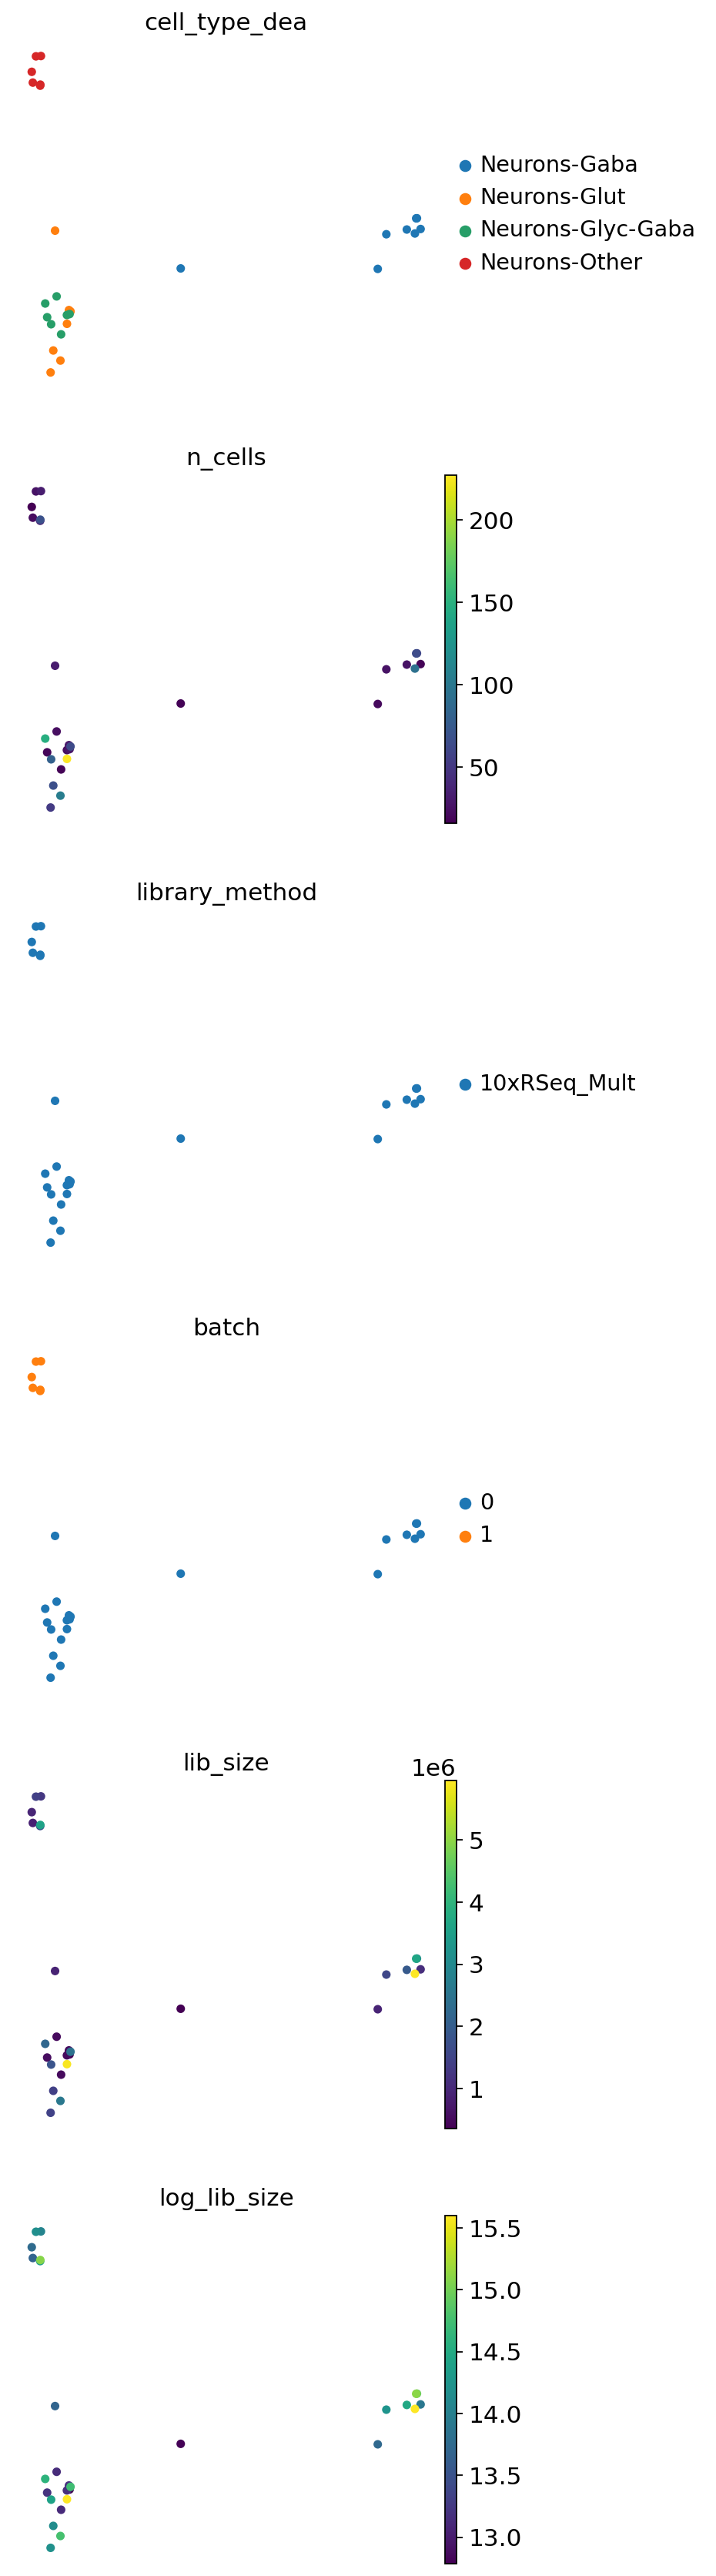

In [72]:
sc.pl.pca(
    adata_pb,
    color=adata_pb.obs.drop(columns=["celltypedea_donorid", "donor_id"]),
    ncols=1,
    size=100,
)

In [73]:
adata_pb.X = adata_pb.layers["counts"].copy()

In [74]:
del adata_pb.layers

In [75]:
del adata_pb.uns["cell_type_dea_colors"]
del adata_pb.uns["batch_colors"]

In [76]:
adata_pb

AnnData object with n_obs × n_vars = 28 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'library_method_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [77]:
# for compatibility
adata_pb.obs["lib_size"] = adata_pb.obs["lib_size"].astype(int)
adata_pb.obs["celltypedea_donorid"] = adata_pb.obs["celltypedea_donorid"].astype(
    "category"
)
adata_pb.obs.index = adata_pb.obs["celltypedea_donorid"]

In [78]:
adata_pb.obs.dtypes

cell_type_dea          category
donor_id               category
celltypedea_donorid    category
n_cells                   int64
library_method         category
batch                  category
lib_size                  int64
log_lib_size            float64
dtype: object

In [79]:
import scipy.sparse

adata_pb.X = scipy.sparse.csr_matrix(adata_pb.X, dtype="float32")

In [80]:
adata_pb.X

<28x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 473963 stored elements in Compressed Sparse Row format>

In [81]:
adata_pb.X.max()

355074.0

In [82]:
# save
adata_pb.write(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_merged_Multi_pseudobulks.h5ad.gz",
    ),
    compression="gzip",
)

In [83]:
# load
setdate = "20250129"  # raw counts, pseudobulks
setdate = "20250414"  # raw counts, pseudobulks, updated cell labels
adata = sc.read_h5ad(
    os.path.join(
        data_dir, "misc",
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_merged_Multi_pseudobulks.h5ad.gz",
    )
)

In [84]:
adata

AnnData object with n_obs × n_vars = 28 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'library_method_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [85]:
adata.X.max()

355074.0

# Merge pseudobulk datasets

## Merge

In [86]:
# Find all pseudobulk files
pattern = os.path.join(data_dir, "misc", "scRNAseq_ref_ABCAtlas_Yao2023Nature", "anndata-objects", "*_pseudobulks.h5ad.gz")
files = glob(pattern, recursive=True)
files

['/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250411_merged_v2_pseudobulks.h5ad.gz',
 '/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250411_merged_v3_pseudobulks.h5ad.gz',
 '/cluster2/sfrerich/P18_cellseg_benchmark/misc/scRNAseq_ref_ABCAtlas_Yao2023Nature/anndata-objects/20250414_merged_Multi_pseudobulks.h5ad.gz']

In [87]:
# Load and merge all files
adatas = [sc.read_h5ad(f) for f in files]
merged = adatas[0].concatenate(adatas[1:])

In [88]:
total_input_obs = sum(adata.n_obs for adata in adatas)
assert merged.n_obs == total_input_obs, (
    f"Merged obs ({merged.n_obs}) != sum of input obs ({total_input_obs})"
)

In [89]:
del adatas

In [90]:
merged

AnnData object with n_obs × n_vars = 2767 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    obsm: 'X_pca'

In [91]:
merged.X.max()

21642372.0

In [92]:
merged.obs.index = merged.obs.celltypedea_donorid

In [93]:
# save
merged.write(
    os.path.join(
        data_dir, "misc", 
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        date.today().strftime("%Y%m%d") + "_pseudobulks_all.h5ad.gz",
    ),
    compression="gzip",
)

In [94]:
# load
setdate = "20250129"  # raw counts, pseudobulks, all merged
setdate = "20250414"  # raw counts, pseudobulks, all merged, updated cell labels
adata = sc.read_h5ad(
    os.path.join(
        data_dir, "misc", 
        "scRNAseq_ref_ABCAtlas_Yao2023Nature",
        "anndata-objects",
        setdate + "_pseudobulks_all.h5ad.gz",
    )
)

In [95]:
adata

AnnData object with n_obs × n_vars = 2767 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    obsm: 'X_pca'

In [96]:
adata.X.max()

21642372.0

In [97]:
adata_pb = adata.copy()

## Explore Covariates
on PCA

In [98]:
adata_pb.layers["counts"] = adata_pb.X.copy()
adata_pb.layers["log1p_norm"] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6, layer="log1p_norm")
sc.pp.log1p(adata_pb, layer="log1p_norm")
adata_pb.X = adata_pb.layers["log1p_norm"]

In [99]:
adata_pb.layers

Layers with keys: counts, log1p_norm

In [100]:
adata_pb.layers["log1p_norm"].max()

12.278938

In [101]:
adata_pb.layers["counts"].max()

21642372.0

In [102]:
sc.pp.pca(adata_pb)

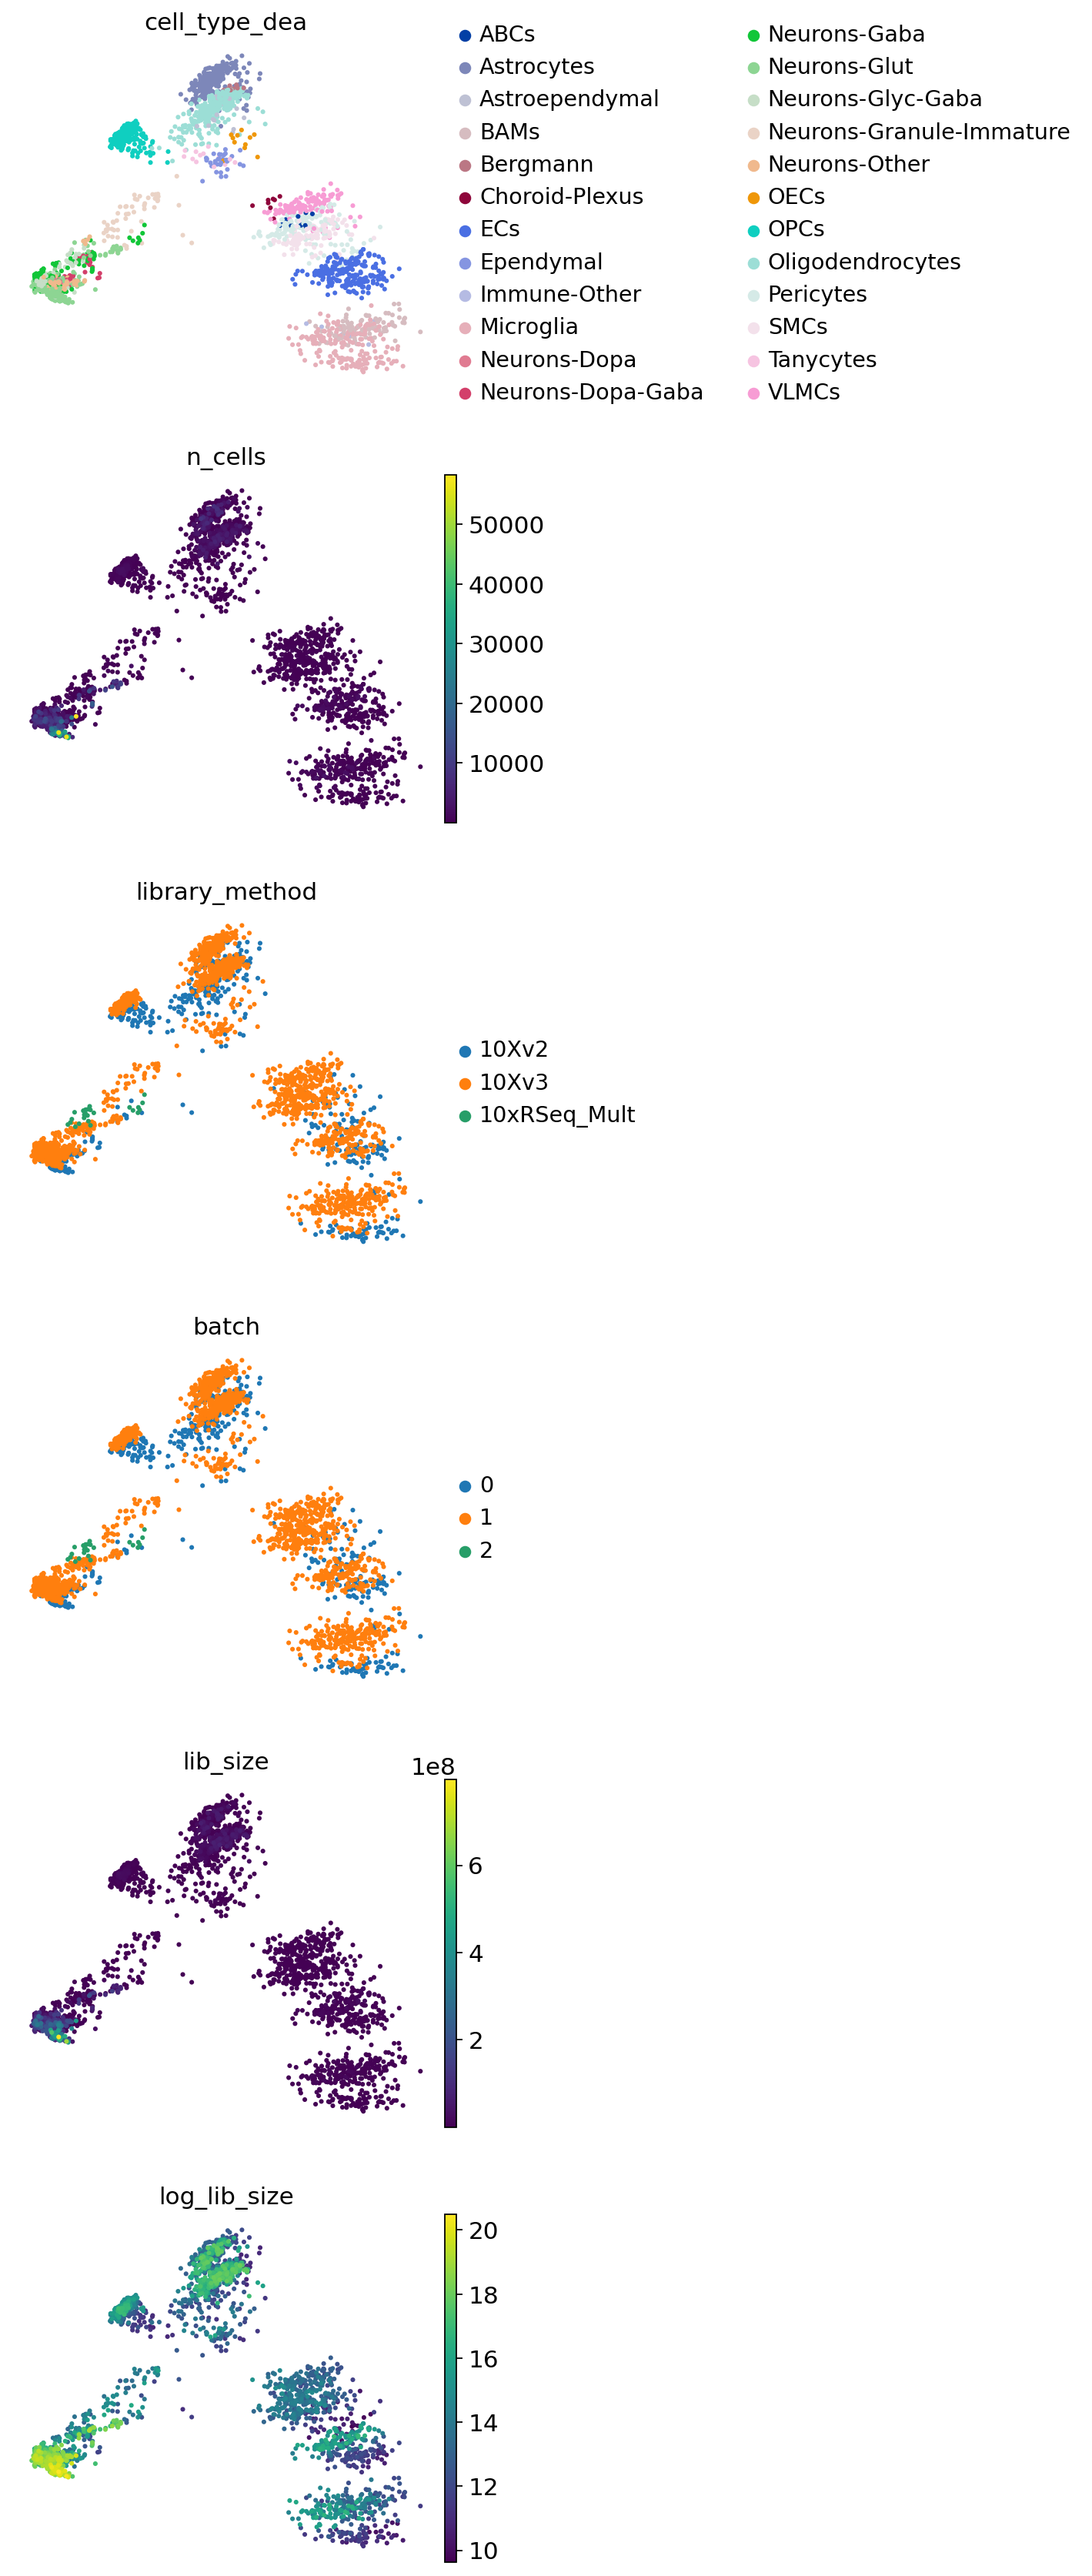

In [103]:
sc.pl.pca(
    adata_pb,
    color=adata_pb.obs.drop(columns=["celltypedea_donorid", "donor_id"]),
    ncols=1,
    size=30,
)